<a href="https://colab.research.google.com/github/kidsage/KaggleStudy/blob/main/batter_ops_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [1]:
from matplotlib import font_manager, rc
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import platform

plt.rc('font', family='NanumBarunGothic') 

#그래프에서 마이너스 기호가 표시되게 하는 설정입니다.
matplotlib.rcParams['axes.unicode_minus'] = False

#**1. KBO 타자 OPS 예측**
> On-base Plus Slugging. 야구에서 타자들을 평가하는 스탯 중 하나로 '출루율 + 장타율'로 계산한다.  



#1.2. 탐색적 데이터 분석


In [2]:
!unzip 62540_KBO_prediction_data.zip

Archive:  62540_KBO_prediction_data.zip
replace Pre_Season_Batter.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: Pre_Season_Batter.csv   
  inflating: Regular_Season_Batter.csv  
  inflating: Regular_Season_Batter_Day_by_Day_b4.csv  
  inflating: submission.csv          


In [3]:
# 프리시즌 데이터 로드
preseason_df = pd.read_csv("Pre_Season_Batter.csv")
# 정규시즌 데이터 로드
regular_season_df = pd.read_csv("Regular_Season_Batter.csv")
# 데이터 크기 확인
print(preseason_df.shape)
# 데이터 상단 출력
display(preseason_df.head())

(1393, 29)


,batter_id,batter_name,year,team,avg,G,AB,R,H,2B,3B,HR,TB,RBI,SB,CS,BB,HBP,SO,GDP,SLG,OBP,E,height/weight,year_born,position,career,starting_salary,OPS
0,0,가르시아,2018,LG,0.350,7,20,1,7,1,0,1,11,5,0,0,2,0,3,1,0.550,0.409,1,177cm/93kg,1985년 04월 12일,내야수(우투우타),쿠바 Ciego de Avila Maximo Gomez Baez(대),NaN,0.959
1,1,강경학,2011,한화,0.000,4,2,2,0,0,0,0,0,1,0,1,0,2,1,0,0.000,0.500,0,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.500
2,1,강경학,2014,한화,-,4,0,2,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,NaN
3,1,강경학,2015,한화,0.130,10,23,3,3,0,0,0,3,1,3,0,4,1,9,0,0.130,0.286,2,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.416
4,1,강경학,2016,한화,0.188,14,32,4,6,1,1,0,9,2,1,2,0,1,10,0,0.281,0.212,0,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.493


In [4]:
# 데이터 기초통계량 확인
display(preseason_df.describe())

,batter_id,year,G,AB,R,H,2B,3B,HR,TB,RBI,SB,CS,BB,HBP,SO,GDP,SLG,OBP,E,OPS
count,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,1393.000000,1364.000000,1368.000000,1393.000000,1364.000000
mean,173.434314,2013.014358,8.705671,19.201723,2.679828,5.021536,0.954774,0.119885,0.391960,7.391960,2.430725,0.629576,0.291457,1.877961,0.330223,3.714286,0.447236,0.361012,0.317912,0.381910,0.676924
std,94.716851,4.166757,5.562686,13.395946,2.637212,4.232584,1.196904,0.379976,0.748557,6.538787,2.698122,1.146854,0.595522,2.053392,0.642204,3.180884,0.723364,0.269892,0.151489,0.729521,0.386933
min,0.000000,2002.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,99.000000,2010.000000,6.000000,9.000000,1.000000,2.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.217000,0.250000,0.000000,0.472000
50%,178.000000,2014.000000,9.000000,18.000000,2.000000,4.000000,1.000000,0.000000,0.000000,6.000000,2.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000,0.344500,0.333000,0.000000,0.675000
75%,254.000000,2017.000000,11.000000,28.000000,4.000000,8.000000,2.000000,0.000000,1.000000,11.000000,4.000000,1.000000,0.000000,3.000000,1.000000,5.000000,1.000000,0.478000,0.400000,1.000000,0.867000
max,344.000000,2018.000000,119.000000,183.000000,35.000000,51.000000,11.000000,4.000000,5.000000,68.000000,24.000000,9.000000,4.000000,21.000000,4.000000,36.000000,5.000000,4.000000,1.000000,5.000000,5.000000


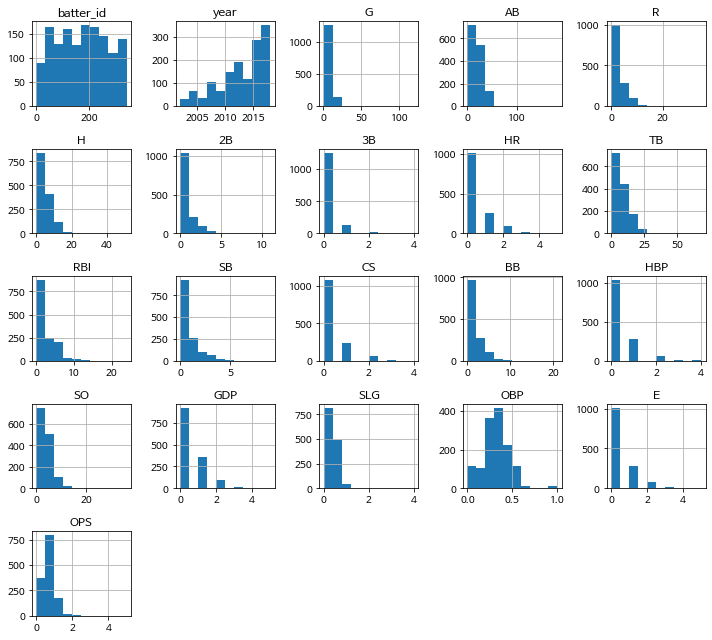

In [5]:
# 데이터 시각화
preseason_df.hist(figsize=(10,9))
plt.tight_layout() # 그래프 간격 설정
plt.show()

In [6]:
# 정규시즌 데이터에서 2002년 이후의 연도별 기록된 선수의 수
# groupby 스킬에 대해 응용력을 높힐 것!
regular_count = regular_season_df.groupby('year')['batter_id'].count().rename('regular')
# 프리시즌 데이터에서 연도별 기록된 선수의 수
preseason_count = preseason_df.groupby('year')['batter_id'].count().rename('preseason')
pd.concat([regular_count,preseason_count, np.round(preseason_count/regular_count,2).rename(
        'ratio')], axis = 1).transpose().loc[:,2002:] # 2002년부터 봅니다.

year,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
regular,43.00,54.00,68.00,73.00,85.00,98.00,115.00,124.00,130.00,151.0,174.0,194.00,186.00,207.00,213.00,217.00,227.0
preseason,12.00,19.00,28.00,37.00,36.00,43.00,61.00,66.00,72.00,75.0,87.0,104.00,117.00,134.00,153.00,167.00,182.0
ratio,0.28,0.35,0.41,0.51,0.42,0.44,0.53,0.53,0.55,0.5,0.5,0.54,0.63,0.65,0.72,0.77,0.8


In [7]:
# 타자의 이름과 연도를 이용해 새로운 인덱스를 생성
regular_season_df['new_idx'] = regular_season_df['batter_name'] + \
                               regular_season_df['year'].apply(str)
preseason_df['new_idx'] = preseason_df['batter_name'] + preseason_df['year'].apply(str)

# 새로운 인덱스의 교집합
intersection_idx = list(set(regular_season_df['new_idx']). \
                        intersection(preseason_df['new_idx']))

# 교집합에 존재하는 데이터만 불러오기
regular_season_new = regular_season_df.loc[
    regular_season_df['new_idx'].apply(lambda x: x in intersection_idx)].copy()
regular_season_new = regular_season_new.sort_values(by = 'new_idx').reset_index(drop=True) 

# 비교를 위해 인덱스로 정렬
preseason_new = preseason_df.loc[preseason_df['new_idx'].apply(
    lambda x: x in intersection_idx)].copy()
preseason_new = preseason_new.sort_values(by = 'new_idx').reset_index(drop=True)

# 검정 코드? 검증?
print(regular_season_new.shape, preseason_new.shape)
sum(regular_season_new['new_idx'] == preseason_new['new_idx'])

(1358, 30) (1358, 30)


1358

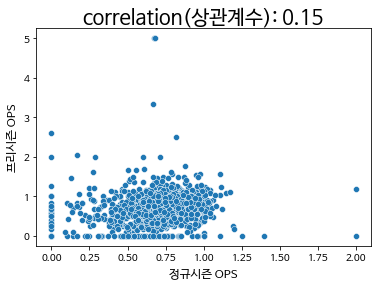

In [8]:
import warnings
warnings.simplefilter("ignore")

correlation = regular_season_new['OPS'].corr(preseason_new['OPS'])
sns.scatterplot(regular_season_new['OPS'], preseason_new['OPS'])
plt.title('correlation(상관계수): '+str(np.round(correlation,2)), fontsize=20)
plt.xlabel("정규시즌 OPS",fontsize=12)
plt.ylabel("프리시즌 OPS",fontsize=12)
plt.show()

# 1.2.2. 정규시즌 데이터 분석

In [9]:
regular_season_df = pd.read_csv("Regular_Season_Batter.csv")
display(regular_season_df.shape, regular_season_df.head(),regular_season_df.describe())

(2454, 29)

,batter_id,batter_name,year,team,avg,G,AB,R,H,2B,3B,HR,TB,RBI,SB,CS,BB,HBP,SO,GDP,SLG,OBP,E,height/weight,year_born,position,career,starting_salary,OPS
0,0,가르시아,2018,LG,0.339,50,183,27,62,9,0,8,95,34,5,0,9,8,25,3,0.519,0.383,9,177cm/93kg,1985년 04월 12일,내야수(우투우타),쿠바 Ciego de Avila Maximo Gomez Baez(대),NaN,0.902
1,1,강경학,2011,한화,0.000,2,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0.000,0.000,1,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.000
2,1,강경학,2014,한화,0.221,41,86,11,19,2,3,1,30,7,0,0,13,2,28,1,0.349,0.337,6,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.686
3,1,강경학,2015,한화,0.257,120,311,50,80,7,4,2,101,27,4,3,40,5,58,3,0.325,0.348,15,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.673
4,1,강경학,2016,한화,0.158,46,101,16,16,3,2,1,26,7,0,0,8,2,30,5,0.257,0.232,7,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.489


,batter_id,year,avg,G,AB,R,H,2B,3B,HR,TB,RBI,SB,CS,BB,HBP,SO,GDP,SLG,OBP,E,OPS
count,2454.000000,2454.000000,2428.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2454.000000,2428.000000,2430.000000,2454.000000,2428.000000
mean,178.079462,2011.614507,0.237559,72.535045,201.514670,29.912388,55.988183,9.863488,0.957620,5.504075,84.279136,27.788509,5.290139,2.335778,20.943765,3.424613,38.596985,4.603504,0.343826,0.306684,3.676447,0.649939
std,97.557947,4.992833,0.098440,45.093871,169.537029,28.778759,52.253844,9.871314,1.647193,7.989380,82.854200,29.602966,9.088580,3.194045,21.206113,4.132614,31.801466,4.713531,0.163335,0.111778,4.585248,0.261634
min,0.000000,1993.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,101.250000,2008.000000,0.203000,28.000000,38.250000,5.000000,8.000000,1.000000,0.000000,0.000000,10.000000,3.000000,0.000000,0.000000,3.000000,0.000000,10.000000,1.000000,0.267454,0.272727,0.000000,0.546000
50%,183.000000,2013.000000,0.255000,79.000000,163.000000,21.000000,40.000000,7.000000,0.000000,2.000000,56.000000,17.000000,2.000000,1.000000,14.000000,2.000000,33.000000,3.000000,0.360124,0.328592,2.000000,0.688637
75%,265.000000,2016.000000,0.291000,115.000000,357.500000,49.000000,100.000000,16.000000,1.000000,8.000000,146.000000,44.000000,6.000000,3.000000,34.000000,5.000000,60.000000,7.000000,0.436000,0.367000,5.000000,0.797234
max,344.000000,2018.000000,1.000000,144.000000,600.000000,135.000000,201.000000,47.000000,17.000000,53.000000,377.000000,146.000000,84.000000,21.000000,108.000000,27.000000,161.000000,24.000000,3.000000,1.000000,30.000000,4.000000


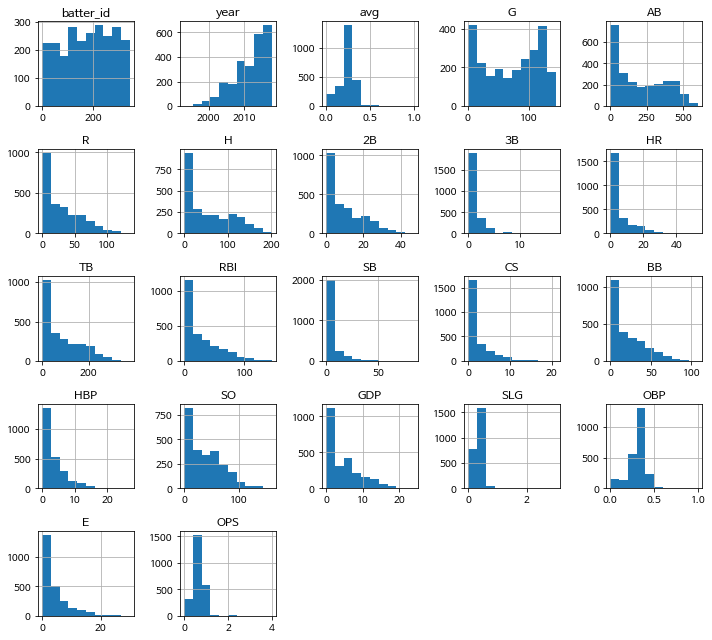

In [10]:
regular_season_df.hist(figsize=(10,9))
plt.tight_layout() # 그래프 간격 설정
plt.show()

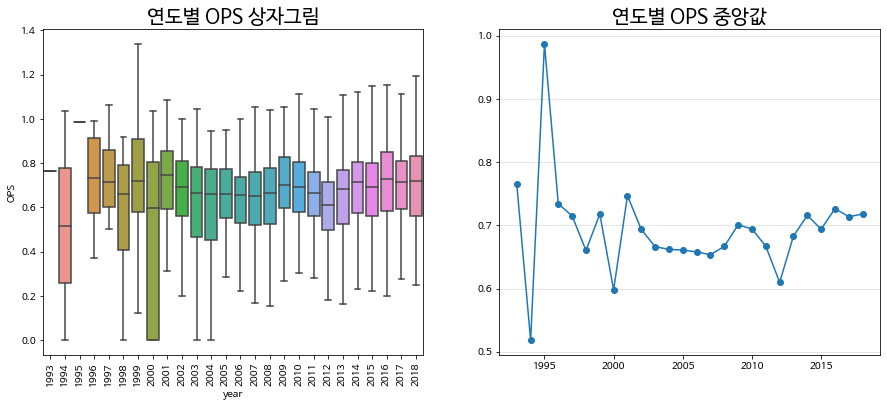

In [11]:
plt.figure(figsize=(15,6)) # 그래프 크기 조정
plt.subplot(1,2,1) # 1행 2열의 첫 번째(1행, 1열) 그래프
g = sns.boxplot(x="year", y="OPS", data=regular_season_df, showfliers=False)
g.set_title('연도별 OPS 상자그림', size = 20)
g.set_xticklabels(g.get_xticklabels(),rotation=90)

plt.subplot(1,2,2)
plt.plot(regular_season_df.groupby('year')['OPS'].median(), marker='o')
plt.grid(axis='y', linestyle='-', alpha=0.4)
plt.title('연도별 OPS 중앙값', size = 20)
plt.show()

In [12]:
pd.crosstab(regular_season_df['year'],'count').T

year,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
col_0,,,,,,,,,,,,,,,,,,,,,,,,,,
count,1,2,1,7,8,10,14,20,32,43,54,68,73,85,98,115,124,130,151,174,194,186,207,213,217,227


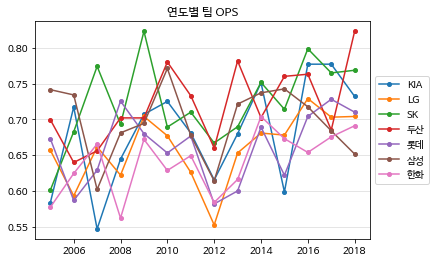

In [13]:
# 연도별 팀의 OPS 중앙값 계산
med_OPS_team = regular_season_df.pivot_table(index=['team'], columns='year',
                                             values='OPS', aggfunc='median')
# 2005년 이후에 결측치가 존재하지 않는 팀만 확인
team_idx = med_OPS_team.loc[:,2005:].isna().sum(axis=1) <= 0

plt.plot(med_OPS_team.loc[team_idx,2005:].T, marker = 'o', markersize=4)
plt.grid(axis='y', linestyle='-', alpha=0.4)
plt.legend(med_OPS_team.loc[team_idx,2005:].T.columns, 
           loc='center left', bbox_to_anchor=(1, 0.5)) # 그래프 범례를 그래프 밖에 위치
plt.title('연도별 팀 OPS')
plt.show()

In [14]:
import re

regular_season_df['weight'] = regular_season_df['height/weight'].apply(
    lambda x: int(re.findall('\d+',x.split('/')[1])[0]) if pd.notnull(x) else x)

regular_season_df['height'] = regular_season_df['height/weight'].apply(
    lambda x: int(re.findall('\d+',x.split('/')[0])[0]) if pd.notnull(x) else x)

print(regular_season_df['height/weight'][0], regular_season_df['height'][0],
      regular_season_df['weight'][0])

177cm/93kg 177.0 93.0


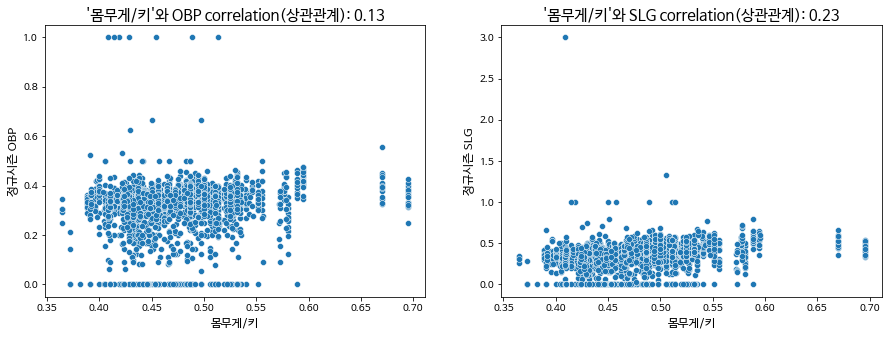

In [15]:
# 몸무게/키 계산
regular_season_df['weight_per_height'] = regular_season_df['weight'] / \
                                         regular_season_df['height']
plt.figure(figsize=(15, 5)) # 그래프 크기 조정
plt.subplot(1, 2, 1) # 1행 2열의 첫번째(1행, 1열) 그래프

# 정규시즌과 프리시즌의 상관관계 계산
correlation = regular_season_df['weight_per_height'].corr(regular_season_df['OBP'])
sns.scatterplot(regular_season_df['weight_per_height'], regular_season_df['OBP'])
plt.title("'몸무게/키'와 OBP correlation(상관관계): " + str(np.round(correlation, 2)), \
          fontsize=15)
plt.ylabel('정규시즌 OBP',fontsize=12)
plt.xlabel('몸무게/키', fontsize=12)
plt.subplot(1, 2, 2)

# 정규시즌과 프리시즌의 상관관계 계산
correlation = regular_season_df['weight_per_height'].corr(regular_season_df['SLG'])
sns.scatterplot(regular_season_df['weight_per_height'], regular_season_df['SLG'])
plt.title("'몸무게/키'와 SLG correlation(상관관계): " + str(np.round(correlation, 2)), \
          fontsize=15)
plt.ylabel('정규시즌 SLG', fontsize=12)
plt.xlabel('몸무게/키', fontsize=12)
plt.show()

In [16]:
regular_season_df['position'].value_counts()

내야수(우투우타)    643
외야수(우투우타)    230
외야수(좌투좌타)    201
포수(우투우타)     189
외야수(우투좌타)    184
내야수(우투좌타)    141
내야수(좌투좌타)     36
포수(우투좌타)      14
외야수(우투양타)      7
내야수(우투양타)      7
Name: position, dtype: int64

In [17]:
# position
regular_season_df['pos']=regular_season_df['position'].apply(
    lambda x: x.split('(')[0] if pd.notnull(x) else x)

# 우타, 좌타, 양타
regular_season_df['hit_way'] = regular_season_df['position'].apply(
    lambda x: x[-3:-1] if pd.notnull(x) else x)
print(regular_season_df['position'][0], regular_season_df['pos'][0], 
      regular_season_df['hit_way'][0])

내야수(우투우타) 내야수 우타


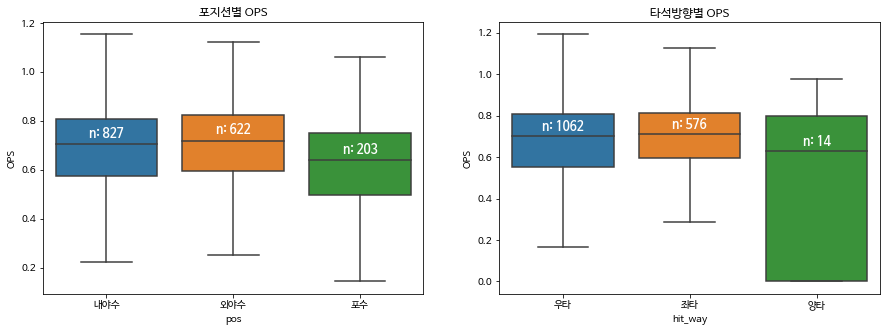

In [18]:
plt.figure(figsize=(15,5)) # 그래프 크기 조정
plt.subplot(1,2,1) # 1행 2열의 첫번째(1행, 1열) 그래프
ax = sns.boxplot(x='pos', y='OPS', data = regular_season_df, showfliers=False)

# position 별 OPS 중앙값
medians = regular_season_df.groupby(['pos'])['OPS'].median().to_dict()

# position별 관측치 수
nobs = regular_season_df['pos'].value_counts().to_dict()

# 키 값을 'n: 값' 형식으로 변환
for key in nobs: nobs[key] = "n: " + str(nobs[key])

# 그래프의 Xticks text 값 얻기
xticks_labels = [item.get_text() for item in ax.get_xticklabels()]

# tick은 tick의 위치, label은 그에 해당하는 text 값
for label in ax.get_xticklabels():
    ax.text(xticks_labels.index(label.get_text()), 
            medians[label.get_text()] + 0.03, nobs[label.get_text()],
            horizontalalignment='center', size='large', color='w', weight='semibold')
    
ax.set_title('포지션별 OPS')

plt.subplot(1,2,2) # 1행 2열의 두 번째(1행, 2열) 그래프
ax = sns.boxplot(x='hit_way', y='OPS', data = regular_season_df, showfliers=False)

# 타자 방향별 OPS 중앙값
medians = regular_season_df.groupby(['hit_way'])['OPS'].median().to_dict()
# 타자 방향 관측치 수
nobs = regular_season_df['hit_way'].value_counts().to_dict()
# 키 값을 'n: 값' 형식으로 변환
for key in nobs: nobs[key] = "n: " + str(nobs[key])

# 그래프의 Xticks text 값 얻기
xticks_labels = [item.get_text() for item in ax.get_xticklabels()]

# tick은 tick의 위치, label은 그에 해당하는 text 값
for label in ax.get_xticklabels():
    ax.text(xticks_labels.index(label.get_text()), medians[label.get_text()] + 0.03,
            nobs[label.get_text()], horizontalalignment='center', size='large',
            color='w', weight='semibold')
ax.set_title('타석방향별 OPS')

plt.show()

In [19]:
regular_season_df['career'].head()

0    쿠바 Ciego de Avila Maximo Gomez Baez(대)
1                         광주대성초-광주동성중-광주동성고
2                         광주대성초-광주동성중-광주동성고
3                         광주대성초-광주동성중-광주동성고
4                         광주대성초-광주동성중-광주동성고
Name: career, dtype: object

In [20]:
# career를 split
foreign_country = regular_season_df['career'].apply(
    lambda x: x.replace('-', ' ').split(' ')[0])

# 외국만 추출
foreign_country_list = list(set(foreign_country.apply(
    lambda x: np.nan if '초' in x else x)))

# 결측치 처리
foreign_country_list = [x for x in foreign_country_list if str(x) != 'nan']
foreign_country_list

['쿠바', '네덜란드', '미국', '도미니카', '캐나다']

In [21]:
regular_season_df['country'] = foreign_country
regular_season_df['country'] = regular_season_df['country'].apply(
    lambda x: x if pd.isnull(x)
                 else ('foreign' if x in foreign_country_list else 'korean'))
regular_season_df[['country']].head()

,country
0,foreign
1,korean
2,korean
3,korean
4,korean


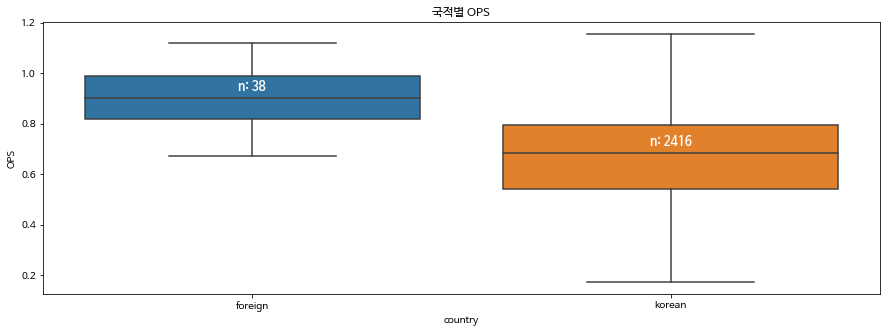

In [22]:
plt.figure(figsize=(15,5)) # 그래프 크기 조정
ax = sns.boxplot(x='country', y='OPS', data = regular_season_df, showfliers=False)

# 내외국인 별 OPS 중앙값 dict
medians = regular_season_df.groupby(['country'])['OPS'].median().to_dict()
# 내외국인 관측치 수 dict
nobs = regular_season_df['country'].value_counts().to_dict()
# 키 값을 'n: 값' 형식으로 변환 
for key in nobs: nobs[key] = "n: " + str(nobs[key])

# 그래프의 Xticks text 값 얻기
xticks_labels = [item.get_text() for item in ax.get_xticklabels()]
    
for label in ax.get_xticklabels(): # tick은 tick의 위치, label은 그에 해당하는 text 값 
    ax.text(xticks_labels.index(label.get_text()), medians[label.get_text()] + 0.03, \
            nobs[label.get_text()], # x 좌표, y 좌표, 해당 text
            horizontalalignment='center', size='large', color='w', weight='semibold') 
ax.set_title('국적별 OPS')
plt.show()

- 대체적으로 용병들이 ops가 높음..

In [23]:
regular_season_df['starting_salary'].value_counts()

10000만원     177
6000만원      117
3000만원      105
9000만원       97
5000만원       91
8000만원       89
30000만원      74
4000만원       62
12000만원      62
18000만원      54
7000만원       53
11000만원      49
13000만원      48
20000만원      46
25000만원      45
15000만원      41
16000만원      28
14000만원      26
28000만원      20
43000만원      17
45000만원      16
27000만원      15
21000만원      13
23000만원      12
33000만원      10
6500만원       10
100000달러      4
300000달러      3
50000달러       2
17000만원       1
Name: starting_salary, dtype: int64

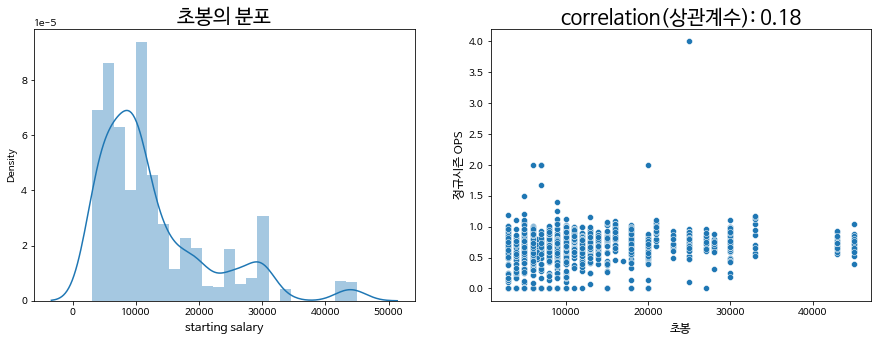

In [24]:
# 결측치라면 그대로 0으로 두고 ‘만원’이 포함되어 있다면 숫자만 뽑아서 초봉으로 넣어준다. 그외 만 원 단위가 아닌 초봉은 결측치로 처리한다.
regular_season_df['starting_salary'] = regular_season_df['starting_salary'].apply(
    lambda x: x if pd.isnull(x)
                 else(int(re.findall('\d+',x)[0]) if '만원' in x else np.nan))

plt.figure(figsize=(15,5)) # 그래프 크기 조정
plt.subplot(1,2,1) # 1행 2열의 첫 번째(1행, 1열) 그래프
b=sns.distplot(regular_season_df['starting_salary']. \
               loc[regular_season_df['starting_salary'].notnull()], hist=True)
b.set_xlabel("starting salary",fontsize=12)
b.set_title('초봉의 분포', fontsize=20)

plt.subplot(1,2,2) # 1행 2열의 두 번째(1행, 2열) 그래프

# 정규시즌과 프리시즌의 상관관계 계산
correlation = regular_season_df['starting_salary'].corr(regular_season_df['OPS'])
b = sns.scatterplot(regular_season_df['starting_salary'], regular_season_df['OPS'])
b.axes.set_title('correlation(상관계수): '+str(np.round(correlation,2)), fontsize=20)
b.set_ylabel("정규시즌 OPS",fontsize=12)
b.set_xlabel("초봉",fontsize=12)
plt.show()

# 1.2.3. 일별 데이터 분석

In [25]:
day_by_day_df = pd.read_csv('Regular_Season_Batter_Day_by_Day_b4.csv')
display(day_by_day_df.shape, day_by_day_df.head())

(112273, 20)

,batter_id,batter_name,date,opposing_team,avg1,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,HBP,SO,GDP,avg2,year
0,0,가르시아,3.24,NC,0.333,3,1,1,0,0,0,0,0,0,1,0,1,0,0.333,2018
1,0,가르시아,3.25,NC,0.000,4,0,0,0,0,0,0,0,0,0,0,1,0,0.143,2018
2,0,가르시아,3.27,넥센,0.200,5,0,1,0,0,0,0,0,0,0,0,0,0,0.167,2018
3,0,가르시아,3.28,넥센,0.200,5,1,1,0,0,0,1,0,0,0,0,0,0,0.176,2018
4,0,가르시아,3.29,넥센,0.250,4,0,1,0,0,0,3,0,0,0,0,0,1,0.190,2018


In [26]:
# 날짜(date)를 ‘.’을 기준으로 나누고 첫 번째 값을 월(month)로 지정 
day_by_day_df['month'] = day_by_day_df['date'].apply(lambda x: str(x).split('.')[0])

# 각 연도의 월별 평균 누적 타율(avg2) 계산
agg_df = day_by_day_df.groupby(['year','month'])['avg2'].mean().reset_index()

# pivot_table을 이용해 데이터 변형
agg_df = agg_df.pivot_table(index=['month'], columns='year', values = 'avg2')
agg_df

year,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
month,,,,,,,,,,,,,,,,,,
10,0.356400,0.269065,0.216583,0.203636,NaN,0.260985,0.249888,0.249638,0.033333,NaN,0.243526,0.246949,0.257841,0.273537,0.274042,0.282547,0.280289,0.277482
3,NaN,NaN,NaN,NaN,NaN,0.261714,0.261714,0.271982,NaN,0.239861,NaN,NaN,0.231236,0.210598,0.214485,0.257857,0.161979,0.238015
4,0.205217,0.319792,0.250296,0.259663,0.235317,0.267106,0.215703,0.261531,0.252546,0.262953,0.247133,0.234199,0.267994,0.259918,0.255175,0.266711,0.259430,0.263953
5,0.297157,0.267990,0.241491,0.237954,0.253527,0.264283,0.237329,0.262535,0.280842,0.272934,0.250877,0.247844,0.268355,0.273899,0.261307,0.275240,0.274374,0.274083
6,0.306926,0.275867,0.252290,0.248800,0.249913,0.264392,0.260600,0.270766,0.278781,0.274791,0.263264,0.254577,0.270533,0.283480,0.268999,0.276307,0.279060,0.280630
7,0.293171,0.266650,0.244230,0.251973,0.256396,0.262464,0.259171,0.264870,0.275054,0.265501,0.264829,0.261513,0.262812,0.275677,0.272685,0.283192,0.284565,0.280817
8,0.303489,0.270481,0.252319,0.249460,0.243570,0.265369,0.270258,0.265173,0.271796,0.271075,0.262048,0.258069,0.268122,0.282025,0.272377,0.283105,0.283283,0.283923
9,0.308636,0.248333,0.243780,0.203953,0.237058,0.258794,0.251022,0.252942,0.264468,0.265312,0.258500,0.251232,0.260571,0.272411,0.271629,0.276513,0.273213,0.277841


year,2011,2012,2013,2014,2015,2016,2017,2018
month,,,,,,,,
4,0.247133,0.234199,0.267994,0.259918,0.255175,0.266711,0.259430,0.263953
5,0.250877,0.247844,0.268355,0.273899,0.261307,0.275240,0.274374,0.274083
6,0.263264,0.254577,0.270533,0.283480,0.268999,0.276307,0.279060,0.280630
7,0.264829,0.261513,0.262812,0.275677,0.272685,0.283192,0.284565,0.280817
8,0.262048,0.258069,0.268122,0.282025,0.272377,0.283105,0.283283,0.283923
9,0.258500,0.251232,0.260571,0.272411,0.271629,0.276513,0.273213,0.277841


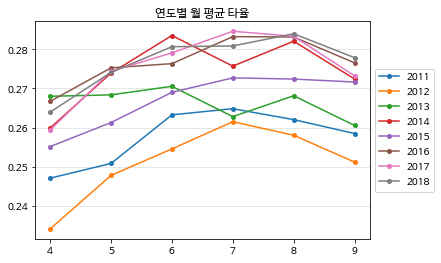

In [27]:
display(agg_df.iloc[2:, 10:])
plt.plot(agg_df.iloc[2:,10:], marker = 'o', markersize=4) # 2011~2018년 데이터만 이용
plt.grid(axis='y', linestyle='-', alpha=0.4)
plt.legend(agg_df.iloc[2:,10:].columns,
           loc='center left', bbox_to_anchor=(1, 0.5)) # 범례 그래프 밖에 위치
plt.title('연도별 월 평균 타율')
plt.show()

# 1.3. 데이터 전처리

In [28]:
pd.DataFrame(regular_season_df.isna().sum()).transpose()

,batter_id,batter_name,year,team,avg,G,AB,R,H,2B,3B,HR,TB,RBI,SB,CS,BB,HBP,SO,GDP,SLG,OBP,E,height/weight,year_born,position,career,starting_salary,OPS,weight,height,weight_per_height,pos,hit_way,country
0,0,0,0,0,26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,26,24,0,802,0,802,0,1076,26,802,802,802,802,802,0


In [29]:
# 수치형 타입의 변수 저장
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64'] # 모든 numeric(수치형) 타입
num_cols = regular_season_df.select_dtypes(include=numerics).columns

# 수치형 타입 변수 중 결측치가 하나라도 존재하는 행 출력
# isna().sum(axis=1) -> 열 기준의 결측치 개수
# df.loc[]를 통해 결측치 0개 이상 데이터를 추출
regular_season_df.loc[regular_season_df[num_cols].isna().sum(axis=1) > 0,num_cols].head()

,batter_id,year,avg,G,AB,R,H,2B,3B,HR,TB,RBI,SB,CS,BB,HBP,SO,GDP,SLG,OBP,E,starting_salary,OPS,weight,height,weight_per_height
0,0,2018,0.339,50,183,27,62,9,0,8,95,34,5,0,9,8,25,3,0.519000,0.383000,9,NaN,0.902000,93.0,177.0,0.525424
12,138,2005,0.127,39,63,9,8,2,0,0,10,3,1,2,7,4,15,1,0.158730,0.256757,3,NaN,0.415487,NaN,NaN,NaN
13,138,2006,0.139,37,36,6,5,2,0,0,7,0,1,0,8,2,14,0,0.194444,0.326087,4,NaN,0.520531,NaN,NaN,NaN
14,138,2007,0.000,8,4,3,0,0,0,0,0,0,0,0,0,0,2,1,0.000000,0.000000,0,NaN,0.000000,NaN,NaN,NaN
15,138,2008,0.000,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0,NaN,0.000000,NaN,NaN,NaN


In [30]:
# 수치형 변수에 포함되는 데이터 타입 선정
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

# 정규 시즌 데이터에서 결측치를 0으로 채우기
regular_season_df[regular_season_df.select_dtypes(include=numerics).columns] = \
    regular_season_df[regular_season_df.select_dtypes(include=numerics).columns].fillna(0)
regular_season_df

,batter_id,batter_name,year,team,avg,G,AB,R,H,2B,3B,HR,TB,RBI,SB,CS,BB,HBP,SO,GDP,SLG,OBP,E,height/weight,year_born,position,career,starting_salary,OPS,weight,height,weight_per_height,pos,hit_way,country
0,0,가르시아,2018,LG,0.339,50,183,27,62,9,0,8,95,34,5,0,9,8,25,3,0.519,0.383,9,177cm/93kg,1985년 04월 12일,내야수(우투우타),쿠바 Ciego de Avila Maximo Gomez Baez(대),0.0,0.902,93.0,177.0,0.525424,내야수,우타,foreign
1,1,강경학,2011,한화,0.000,2,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0.000,0.000,1,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000.0,0.000,72.0,180.0,0.400000,내야수,좌타,korean
2,1,강경학,2014,한화,0.221,41,86,11,19,2,3,1,30,7,0,0,13,2,28,1,0.349,0.337,6,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000.0,0.686,72.0,180.0,0.400000,내야수,좌타,korean
3,1,강경학,2015,한화,0.257,120,311,50,80,7,4,2,101,27,4,3,40,5,58,3,0.325,0.348,15,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000.0,0.673,72.0,180.0,0.400000,내야수,좌타,korean
4,1,강경학,2016,한화,0.158,46,101,16,16,3,2,1,26,7,0,0,8,2,30,5,0.257,0.232,7,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000.0,0.489,72.0,180.0,0.400000,내야수,좌타,korean
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2449,344,황진수,2014,롯데,0.000,5,5,0,0,0,0,0,0,0,0,0,0,0,1,0,0.000,0.000,0,181cm/82kg,1989년 02월 15일,내야수(우투양타),석천초-대헌중-공주고,4000.0,0.000,82.0,181.0,0.453039,내야수,양타,korean
2450,344,황진수,2015,롯데,0.000,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0.000,0,181cm/82kg,1989년 02월 15일,내야수(우투양타),석천초-대헌중-공주고,4000.0,0.000,82.0,181.0,0.453039,내야수,양타,korean
2451,344,황진수,2016,롯데,0.000,11,10,2,0,0,0,0,0,0,0,1,0,0,5,0,0.000,0.000,0,181cm/82kg,1989년 02월 15일,내야수(우투양타),석천초-대헌중-공주고,4000.0,0.000,82.0,181.0,0.453039,내야수,양타,korean
2452,344,황진수,2017,롯데,0.291,60,117,18,34,6,2,1,47,16,4,0,10,3,38,2,0.402,0.359,4,181cm/82kg,1989년 02월 15일,내야수(우투양타),석천초-대헌중-공주고,4000.0,0.761,82.0,181.0,0.453039,내야수,양타,korean


In [31]:
# 일별 데이터에서 결측치를 0으로 채우기
day_by_day_df[day_by_day_df.select_dtypes(include=numerics).columns] = \
    day_by_day_df[day_by_day_df.select_dtypes(include=numerics).columns].fillna(0)
day_by_day_df

,batter_id,batter_name,date,opposing_team,avg1,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,HBP,SO,GDP,avg2,year,month
0,0,가르시아,3.24,NC,0.333,3,1,1,0,0,0,0,0,0,1,0,1,0,0.333,2018,3
1,0,가르시아,3.25,NC,0.000,4,0,0,0,0,0,0,0,0,0,0,1,0,0.143,2018,3
2,0,가르시아,3.27,넥센,0.200,5,0,1,0,0,0,0,0,0,0,0,0,0,0.167,2018,3
3,0,가르시아,3.28,넥센,0.200,5,1,1,0,0,0,1,0,0,0,0,0,0,0.176,2018,3
4,0,가르시아,3.29,넥센,0.250,4,0,1,0,0,0,3,0,0,0,0,0,1,0.190,2018,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112268,344,황진수,6.23,LG,-,0,0,0,0,0,0,0,0,0,1,0,0,0,0.158,2018,6
112269,344,황진수,6.26,넥센,0.000,1,0,0,0,0,0,0,0,0,0,0,1,0,0.150,2018,6
112270,344,황진수,6.27,넥센,0.500,2,1,1,1,0,0,0,0,0,0,0,1,0,0.182,2018,6
112271,344,황진수,6.28,넥센,-,0,0,0,0,0,0,0,0,0,0,0,0,0,0.182,2018,6


In [32]:
# 프리시즌 데이터에서 결측치를 0으로 채우기
preseason_df[preseason_df.select_dtypes(include=numerics).columns] = \
    preseason_df[preseason_df.select_dtypes(include=numerics).columns].fillna(0)
preseason_df

,batter_id,batter_name,year,team,avg,G,AB,R,H,2B,3B,HR,TB,RBI,SB,CS,BB,HBP,SO,GDP,SLG,OBP,E,height/weight,year_born,position,career,starting_salary,OPS,new_idx
0,0,가르시아,2018,LG,0.350,7,20,1,7,1,0,1,11,5,0,0,2,0,3,1,0.550,0.409,1,177cm/93kg,1985년 04월 12일,내야수(우투우타),쿠바 Ciego de Avila Maximo Gomez Baez(대),NaN,0.959,가르시아2018
1,1,강경학,2011,한화,0.000,4,2,2,0,0,0,0,0,1,0,1,0,2,1,0,0.000,0.500,0,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.500,강경학2011
2,1,강경학,2014,한화,-,4,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0.000,0,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.000,강경학2014
3,1,강경학,2015,한화,0.130,10,23,3,3,0,0,0,3,1,3,0,4,1,9,0,0.130,0.286,2,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.416,강경학2015
4,1,강경학,2016,한화,0.188,14,32,4,6,1,1,0,9,2,1,2,0,1,10,0,0.281,0.212,0,180cm/72kg,1992년 08월 11일,내야수(우투좌타),광주대성초-광주동성중-광주동성고,10000만원,0.493,강경학2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1388,342,황재균,2014,롯데,0.407,10,27,3,11,2,0,1,16,4,1,0,2,0,5,0,0.593,0.448,1,183cm/96kg,1987년 07월 28일,내야수(우투우타),사당초-이수중-경기고-현대-우리-히어로즈-넥센-롯데-샌프란시스코,6000만원,1.041,황재균2014
1389,342,황재균,2015,롯데,0.333,11,30,8,10,3,0,0,13,6,0,0,4,0,3,0,0.433,0.389,0,183cm/96kg,1987년 07월 28일,내야수(우투우타),사당초-이수중-경기고-현대-우리-히어로즈-넥센-롯데-샌프란시스코,6000만원,0.822,황재균2015
1390,342,황재균,2016,롯데,0.310,16,42,8,13,3,1,0,18,4,3,1,4,0,4,0,0.429,0.370,1,183cm/96kg,1987년 07월 28일,내야수(우투우타),사당초-이수중-경기고-현대-우리-히어로즈-넥센-롯데-샌프란시스코,6000만원,0.799,황재균2016
1391,342,황재균,2018,KT,0.250,6,16,3,4,1,0,1,8,4,0,0,2,0,6,0,0.500,0.333,3,183cm/96kg,1987년 07월 28일,내야수(우투우타),사당초-이수중-경기고-현대-우리-히어로즈-넥센-롯데-샌프란시스코,6000만원,0.833,황재균2018


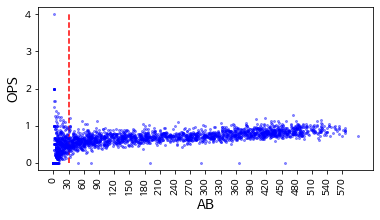

In [33]:
plt.figure(figsize=(6, 3)) # 크기 조정
plt.plot('AB', 'OPS', data=regular_season_df, linestyle='none', marker='o', 
         markersize=2, color='blue', alpha=0.4)
plt.xlabel('AB', fontsize=14)
plt.ylabel('OPS', fontsize=14)
plt.xticks(list(range(min(regular_season_df['AB']), max(regular_season_df['AB']), 30)),
           rotation=90)
plt.vlines(30,ymin=min(regular_season_df['OPS']),ymax=max(regular_season_df['OPS']),
           linestyles='dashed', colors='r')
plt.show()

In [34]:
# OPS 이상치 탐색을 위한 수치 정의
Q1 = regular_season_df['OPS'].quantile(0.25)
Q3 = regular_season_df['OPS'].quantile(0.75)
IQR = Q3 - Q1

# 실제 OPS 이상치 탐색
regular_season_df.loc[(regular_season_df['OPS'] < (Q1 - 1.5 * IQR)) |
                      (regular_season_df['OPS'] > (Q3 + 1.5 * IQR))].sort_values(
    by=['AB'], axis=0, ascending=False)[['batter_name','AB','year','OPS']].head(10)

,batter_name,AB,year,OPS
2336,테임즈,472,2015,1.293656
1935,정성훈,457,2000,0.000000
97,강정호,418,2014,1.200156
1934,정성훈,366,1999,0.000000
1675,이진영,292,2000,0.000000
1674,이진영,190,1999,0.000000
1457,이범호,74,2000,0.000000
478,김주찬,48,2000,0.000000
1320,유재신,33,2018,1.192000
416,김원섭,25,2005,0.116923


- 7월 일별 경기수의 합

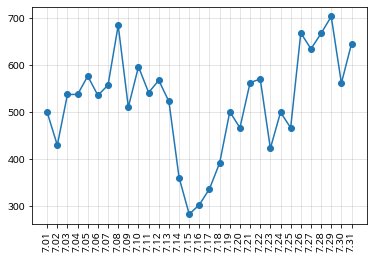

In [35]:
# 7.01~7.31 숫자 생성 후 반 올림
major_ticks = list(np.round(np.linspace(7.01,7.31, 31),2)) 

july = (day_by_day_df['date'] >= 7) & (day_by_day_df['date'] < 8) # 7월만 불러오는 index
plt.plot(major_ticks,
         day_by_day_df['date'].loc[july].value_counts().sort_index(), marker='o')
plt.grid(linestyle='-', alpha=0.4)
plt.xticks(major_ticks,rotation=90)
plt.show()

# 1.3.3. 시간 변수

In [36]:
# 시간 변수를 생성하는 함수 정의
def lag_function(df, var_name, past):
    # df = 시간변수를 생성할 데이터 프레임
    # var_name = 시간변수 생성의 대상이 되는 변수 이름
    # past = 몇 년 전의 성적을 생성할지 결정 (정수형)
    df.reset_index(drop=True, inplace = True)
    
    #시간변수 생성
    df['lag'+str(past)+'_'+var_name] = np.nan;
    df['lag'+str(past)+'_'+'AB'] = np.nan
    
    for col in ['AB', var_name]:
        for i in range(0,(max(df.index)+1)):
            val = df.loc[(df['batter_name'] == df['batter_name'][i]) & 
                         (df['year'] == df['year'][i] - past), col]
            # 과거 기록이 결측치가 아니라면 값을 넣기
            if(len(val) != 0):
                df.loc[i, 'lag' + str(past) + '_' + col] = val.iloc[0]

    #30타수 미만 결측치 처리
    df.loc[df['lag' + str(past) + '_' + 'AB'] < 30, 
           'lag' + str(past) + '_' + var_name] = np.nan
    df.drop('lag' + str(past) + '_' + 'AB', axis = 1, inplace = True)

    return df

Text(0.5, 1.0, 'Diagonal Correlation HeatMap')

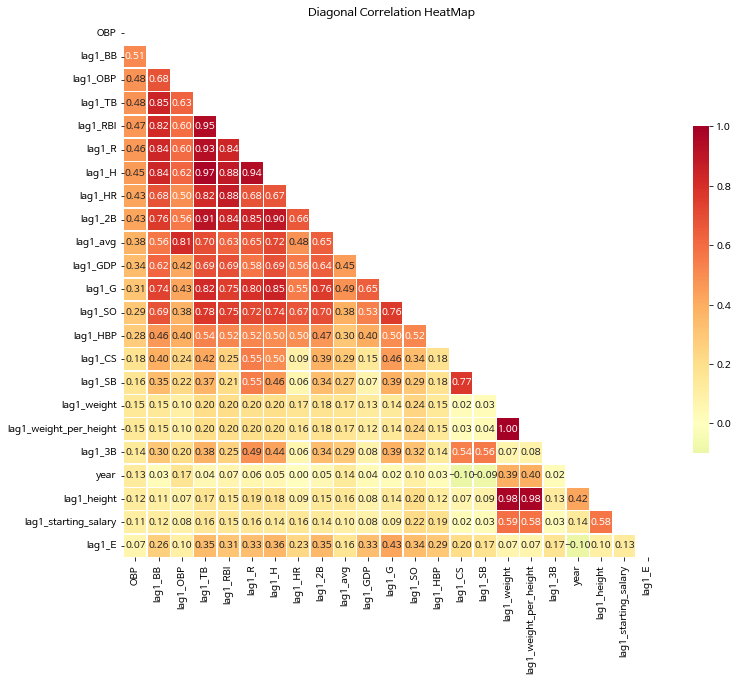

In [37]:
# 상관관계를 탐색할 변수 선택
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_cols = list(regular_season_df.select_dtypes(include=numerics).drop(
    ['batter_id','year','OPS','SLG'], axis =1).columns)
regular_season_temp = regular_season_df[numeric_cols + ['year', 'batter_name']].copy()
regular_season_temp = regular_season_temp.loc[regular_season_temp['AB'] >= 30]

# 시간변수 생성 함수를 통한 지표별 1년 전 성적 추출
for col in numeric_cols:
    regular_season_temp = lag_function(regular_season_temp, col, 1)

numeric_cols.remove('OBP')
regular_season_temp.drop(numeric_cols, axis = 1, inplace= True)

# 상관관계 도출
corr_matrix = regular_season_temp.corr()
corr_matrix = corr_matrix.sort_values(by = 'OBP', axis = 0, ascending=False)
corr_matrix = corr_matrix[corr_matrix.index]

# 상관관계의 시각적 표현
f, ax = plt.subplots(figsize=(12, 12))
corr = regular_season_temp.select_dtypes(exclude=["object","bool"]).corr()

# 대각 행렬을 기준으로 한 쪽만 나타나게 설정해줍니다.
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

g = sns.heatmap(corr_matrix, cmap='RdYlGn_r', vmax= 1, mask=mask, 
center=0, annot=True, fmt='.2f', square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title("Diagonal Correlation HeatMap")

In [38]:
#희생 플라이 구하기
#OBP(출루율) 계산 공식 이용하여 SF(희생 플라이)계산 >> (H+BB+HBP)/OBP-(AB+BB+HBP)
regular_season_df['SF'] = \
    regular_season_df[['H','BB','HBP']].sum(axis=1) / regular_season_df['OBP'] - \
    regular_season_df[['AB','BB','HBP']].sum(axis=1)
regular_season_df['SF'].fillna(0, inplace = True)
regular_season_df['SF'] = regular_season_df['SF'].apply(lambda x : round(x,0))

#한 타수당 평균 희생 플라이 계산 후 필요한 것만 추출
regular_season_df['SF_1'] = regular_season_df['SF'] / regular_season_df['AB']
regular_season_df_SF = regular_season_df[['batter_name','year','SF_1']]
regular_season_df_SF

,batter_name,year,SF_1
0,가르시아,2018,0.032787
1,강경학,2011,0.000000
2,강경학,2014,-0.000000
3,강경학,2015,0.009646
4,강경학,2016,0.009901
...,...,...,...
2449,황진수,2014,0.000000
2450,황진수,2015,0.000000
2451,황진수,2016,0.000000
2452,황진수,2017,0.008547


In [39]:
#day_by_day에서 연도별 선수의 시즌 전반기 출루율과 관련된 성적 합 구하기
sum_hf_yr_OBP = day_by_day_df.loc[day_by_day_df['date'] <= 7.18].groupby(
    ['batter_name','year'])['AB','H','BB','HBP'].sum().reset_index()

#day_by_day와 regular season에서 구한 희생 플라이 관련 데이터를 합치기
sum_hf_yr_OBP = sum_hf_yr_OBP.merge(regular_season_df_SF, how = 'left',
                                    on=['batter_name','year'])

#선수별 전반기 희생 플라이 수 계산
sum_hf_yr_OBP['SF'] = (sum_hf_yr_OBP['SF_1']*sum_hf_yr_OBP['AB']).apply(
    lambda x: round(x, 0))
sum_hf_yr_OBP.drop('SF_1', axis = 1, inplace = True)

#선수별 전반기 OBP(출루율) 계산
sum_hf_yr_OBP['OBP'] = sum_hf_yr_OBP[['H', 'BB', 'HBP']].sum(axis = 1) / \
                       sum_hf_yr_OBP[['AB', 'BB', 'HBP','SF']].sum(axis = 1)
# OBP 결측치를 0으로 처리 
sum_hf_yr_OBP['OBP'].fillna(0, inplace = True)

# 분석에 필요하지 않은 열 제거
sum_hf_yr_OBP = sum_hf_yr_OBP[['batter_name','year','AB','OBP']]
sum_hf_yr_OBP

,batter_name,year,AB,OBP
0,가르시아,2018,85,0.418367
1,강경학,2011,1,0.000000
2,강경학,2014,0,1.000000
3,강경학,2015,156,0.342541
4,강경학,2016,81,0.222222
...,...,...,...,...
1381,황진수,2012,4,0.400000
1382,황진수,2013,0,0.000000
1383,황진수,2016,9,0.000000
1384,황진수,2017,71,0.316456


# 1.3.4. 추가 변수 생성
>나이별 평균 성적

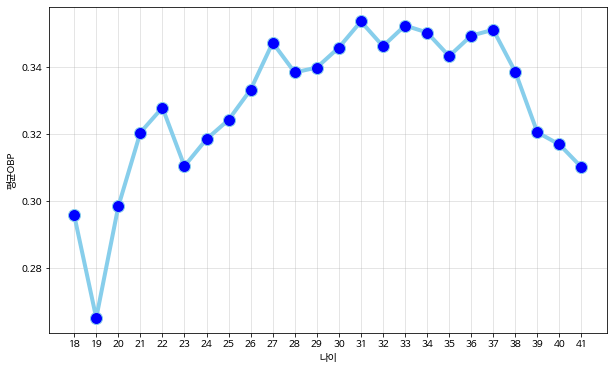

In [40]:
# 나이 변수 생성
regular_season_df['age'] = regular_season_df['year'] - \
                           regular_season_df['year_born'].apply(lambda x: int(x[:4]))

# 나이, 평균 출루율, 출루율 중위값으로 구성된 데이터프레임 구축
temp_df = regular_season_df.loc[regular_season_df['AB'] >= 30].groupby('age').agg(
    {'OBP':['mean','median']}).reset_index()
temp_df.columns = temp_df.columns.droplevel()
temp_df.columns = ['age', 'mean_OBP', 'median_OBP']

# 나이에 따른 출루율 추이 시각화
plt.figure(figsize=(10,6))
plt.plot('age', 'mean_OBP', data=temp_df, marker='o', markerfacecolor='blue',
         markersize=12, color='skyblue', linewidth=4)
plt.xticks(temp_df['age']) # 나이 표시
plt.grid(linestyle='-', alpha=0.4)
plt.ylabel('평균OBP')
plt.xlabel('나이')
plt.show()

In [41]:
# 나이를 포함한 변수 선택
sum_hf_yr_OBP = sum_hf_yr_OBP.merge(regular_season_df[['batter_name','year','age']],
                                    how = 'left', on=['batter_name','year'])

# 총 3년 전 성적까지 변수를 생성
sum_hf_yr_OBP = lag_function(sum_hf_yr_OBP, "OBP", 1)
sum_hf_yr_OBP = lag_function(sum_hf_yr_OBP, "OBP", 2)
sum_hf_yr_OBP = lag_function(sum_hf_yr_OBP, "OBP", 3)
sum_hf_yr_OBP

,batter_name,year,AB,OBP,age,lag1_OBP,lag2_OBP,lag3_OBP
0,가르시아,2018,85,0.418367,33,NaN,NaN,NaN
1,강경학,2011,1,0.000000,19,NaN,NaN,NaN
2,강경학,2014,0,1.000000,22,NaN,NaN,NaN
3,강경학,2015,156,0.342541,23,NaN,NaN,NaN
4,강경학,2016,81,0.222222,24,0.342541,NaN,NaN
...,...,...,...,...,...,...,...,...
1381,황진수,2012,4,0.400000,23,NaN,NaN,NaN
1382,황진수,2013,0,0.000000,24,NaN,NaN,NaN
1383,황진수,2016,9,0.000000,27,NaN,NaN,NaN
1384,황진수,2017,71,0.316456,28,NaN,NaN,NaN


# 1.3.5. 데이터 사후 처리

In [42]:
round(sum_hf_yr_OBP[['lag1_OBP','lag2_OBP','lag3_OBP']].isna().sum() / \
      sum_hf_yr_OBP.shape[0], 2)

lag1_OBP    0.41
lag2_OBP    0.54
lag3_OBP    0.61
dtype: float64

In [43]:
#1. 선수별 OBP 평균
# SF = (H+BB+HBP) / OBP-(AB+BB+HBP)
# OBP = (H+BB+HBP) / (AB+BB+HBP+SF)
player_OBP_mean = regular_season_df.loc[regular_season_df['AB'] >= 30].groupby(
    'batter_name')['AB','H','BB','HBP','SF'].sum().reset_index()
player_OBP_mean['mean_OBP'] = player_OBP_mean[['H', 'BB', 'HBP']].sum(axis=1) / \
                            player_OBP_mean[['AB','BB','HBP','SF']].sum(axis=1)

#2. 시즌별 OBP 평균
season_OBP_mean = regular_season_df.loc[regular_season_df['AB'] >= 30].groupby(
    'year')['AB','H','BB','HBP','SF'].sum().reset_index()
season_OBP_mean['mean_OBP'] = season_OBP_mean[['H', 'BB', 'HBP']].sum(axis=1) / \
                              season_OBP_mean[['AB','BB','HBP','SF']].sum(axis=1)
season_OBP_mean = season_OBP_mean[['year', 'mean_OBP']]

#### player_OBP_mean(선수평균) 열 추가
sum_hf_yr_OBP = sum_hf_yr_OBP.merge(player_OBP_mean[['batter_name', 'mean_OBP']],
                                    how ='left', on="batter_name")
sum_hf_yr_OBP = \
    sum_hf_yr_OBP.loc[~sum_hf_yr_OBP['mean_OBP'].isna()].reset_index(drop=True)
sum_hf_yr_OBP

,batter_name,year,AB,OBP,age,lag1_OBP,lag2_OBP,lag3_OBP,mean_OBP
0,가르시아,2018,85,0.418367,33,NaN,NaN,NaN,0.383495
1,강경학,2011,1,0.000000,19,NaN,NaN,NaN,0.337880
2,강경학,2014,0,1.000000,22,NaN,NaN,NaN,0.337880
3,강경학,2015,156,0.342541,23,NaN,NaN,NaN,0.337880
4,강경학,2016,81,0.222222,24,0.342541,NaN,NaN,0.337880
...,...,...,...,...,...,...,...,...,...
1347,황진수,2012,4,0.400000,23,NaN,NaN,NaN,0.358779
1348,황진수,2013,0,0.000000,24,NaN,NaN,NaN,0.358779
1349,황진수,2016,9,0.000000,27,NaN,NaN,NaN,0.358779
1350,황진수,2017,71,0.316456,28,NaN,NaN,NaN,0.358779


In [44]:
# 결측치 처리하는 함수 정의
def lag_na_fill(data_set, var_name, past, season_var_mean_data):
    # data_Set: 이용할 데이터셋
    # var_name: 시간 변수를 만들 변수 이름
    # past: 몇 년 전 변수를 만들지 결정
    # season_var_name_mean_data season별로 var_name의 평균을 구한 데이터
  
    for i in range(0,len(data_set)):
        if np.isnan(data_set["lag"+str(past)+"_"+var_name][i]):
            data_set.loc[i,["lag"+str(past)+"_"+var_name]] = (
                data_set["mean" + "_" + var_name][i] + season_var_mean_data.loc[
                    season_var_mean_data['year'] == (data_set['year'][i] - past),
                    "mean_" + var_name].iloc[0]
                ) / 2
    return data_set

In [45]:
sum_hf_yr_OBP = lag_na_fill(sum_hf_yr_OBP, "OBP", 1, season_OBP_mean) # 1년 전 성적 대체
sum_hf_yr_OBP = lag_na_fill(sum_hf_yr_OBP, "OBP", 2, season_OBP_mean) # 2년 전 성적 대체
sum_hf_yr_OBP = lag_na_fill(sum_hf_yr_OBP, "OBP", 3, season_OBP_mean) # 3년 전 성적 대체
sum_hf_yr_OBP

,batter_name,year,AB,OBP,age,lag1_OBP,lag2_OBP,lag3_OBP,mean_OBP
0,가르시아,2018,85,0.418367,33,0.369982,0.375910,0.373119,0.383495
1,강경학,2011,1,0.000000,19,0.347434,0.348603,0.344259,0.337880
2,강경학,2014,0,1.000000,22,0.346682,0.337511,0.343131,0.337880
3,강경학,2015,156,0.342541,23,0.353425,0.346682,0.337511,0.337880
4,강경학,2016,81,0.222222,24,0.342541,0.353425,0.346682,0.337880
...,...,...,...,...,...,...,...,...,...
1347,황진수,2012,4,0.400000,23,0.353580,0.357883,0.359052,0.358779
1348,황진수,2013,0,0.000000,24,0.347960,0.353580,0.357883,0.358779
1349,황진수,2016,9,0.000000,27,0.360760,0.363874,0.357131,0.358779
1350,황진수,2017,71,0.316456,28,0.363552,0.360760,0.363874,0.358779


# 1.3.6. SLG 데이터 전처리

Text(0.5, 1.0, 'Diagonal Correlation HeatMap')

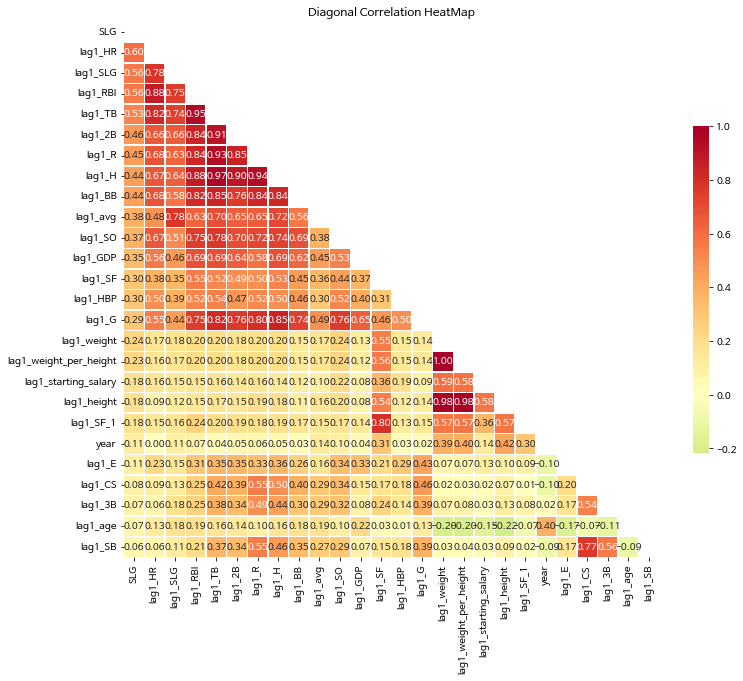

In [46]:
# 상관관계를 탐색할 변수 선택
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_cols = list(regular_season_df.select_dtypes(include=numerics).drop(
    ['batter_id','year','OPS','OBP'], axis =1).columns)
regular_season_temp = regular_season_df[numeric_cols + ['year', 'batter_name']].copy()
regular_season_temp = regular_season_temp.loc[regular_season_temp['AB']>=30]

# 시간변수 생성 함수를 통한 지표별 1년 전 성적 추출
for col in numeric_cols:
    regular_season_temp = lag_function(regular_season_temp, col, 1)

numeric_cols.remove('SLG')
regular_season_temp.drop(numeric_cols, axis = 1, inplace=True)

# 상관관계 도출
corr_matrix = regular_season_temp.corr()
corr_matrix = corr_matrix.sort_values(by = 'SLG', axis = 0, ascending=False)
corr_matrix = corr_matrix[corr_matrix.index]

# 상관관계의 시각적 표현
f, ax = plt.subplots(figsize=(12, 12))
corr = regular_season_temp.select_dtypes(exclude=["object","bool"]).corr()

# 대각 행렬을 기준으로 한쪽만 나타나게 설정해줍니다.
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

cmap = sns.diverging_palette(220, 10, as_cmap=True)
g = sns.heatmap(corr_matrix, cmap='RdYlGn_r', vmax=1, mask=mask, center=0, annot=True,
                fmt='.2f', square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title("Diagonal Correlation HeatMap")

In [47]:
# day_by_day에서 연도별 선수의 시즌 전반기 장타율(SLG)과 관련된 성적 합 구하기
sum_hf_yr_SLG = day_by_day_df.loc[day_by_day_df['date'] <= 7.18].groupby(
    ['batter_name','year'])['AB','H','2B','3B', 'HR'].sum().reset_index()

# 전반기 장타율 계산
sum_hf_yr_SLG['SLG'] = \
    (sum_hf_yr_SLG['H'] - sum_hf_yr_SLG[['2B', '3B', 'HR']].sum(axis=1) +
     sum_hf_yr_SLG['2B']*2 + sum_hf_yr_SLG['3B']*3 + sum_hf_yr_SLG['HR']*4
     ) / sum_hf_yr_SLG['AB']

# SLG 결측치를 0으로 처리 
sum_hf_yr_SLG['SLG'].fillna(0, inplace=True)

# 필요한 칼럼만 불러오고 나이 계산
sum_hf_yr_SLG = sum_hf_yr_SLG[['batter_name','year','AB','SLG']]
sum_hf_yr_SLG = sum_hf_yr_SLG.merge(regular_season_df[['batter_name','year','age']],
                                    how='left', on=['batter_name','year'])
sum_hf_yr_SLG.head()

,batter_name,year,AB,SLG,age
0,가르시아,2018,85,0.552941,33
1,강경학,2011,1,0.000000,19
2,강경학,2014,0,0.000000,22
3,강경학,2015,156,0.333333,23
4,강경학,2016,81,0.222222,24


In [48]:
# 총 3년 전 성적까지 변수를 생성
sum_hf_yr_SLG = lag_function(sum_hf_yr_SLG, "SLG", 1)
sum_hf_yr_SLG = lag_function(sum_hf_yr_SLG, "SLG", 2)
sum_hf_yr_SLG = lag_function(sum_hf_yr_SLG, "SLG", 3)
display(sum_hf_yr_SLG.head())

round(sum_hf_yr_SLG[['lag1_SLG', 'lag2_SLG', 'lag3_SLG']].isna().sum()/\
      sum_hf_yr_SLG.shape[0], 2)

,batter_name,year,AB,SLG,age,lag1_SLG,lag2_SLG,lag3_SLG
0,가르시아,2018,85,0.552941,33,NaN,NaN,NaN
1,강경학,2011,1,0.000000,19,NaN,NaN,NaN
2,강경학,2014,0,0.000000,22,NaN,NaN,NaN
3,강경학,2015,156,0.333333,23,NaN,NaN,NaN
4,강경학,2016,81,0.222222,24,0.333333,NaN,NaN


lag1_SLG    0.41
lag2_SLG    0.54
lag3_SLG    0.61
dtype: float64

In [49]:
# 선수별 SLG 평균 데이터(player_SLG_mean)를 만듭니다
player_SLG_mean = regular_season_df.loc[regular_season_df['AB'] >= 30].groupby(
    'batter_name')['AB','H','2B','3B','HR'].sum().reset_index()
player_SLG_mean['mean_SLG'] = \
    (player_SLG_mean['H'] - player_SLG_mean[['2B','3B','HR']].sum(axis = 1) +
     player_SLG_mean['2B']*2 + player_SLG_mean['3B']*3 + player_SLG_mean['HR']*4
    ) / player_SLG_mean['AB']

# 시즌별 SLG 평균 데이터(season_SLG_mean)를 만듭니다
season_SLG_mean = regular_season_df.loc[regular_season_df['AB'] >= 30].groupby(
    'year')['AB','H','2B','3B','HR'].sum().reset_index()
season_SLG_mean['mean_SLG'] = \
    (season_SLG_mean['H'] - season_SLG_mean[['2B','3B','HR']].sum(axis = 1) + 
     season_SLG_mean['2B']*2 + season_SLG_mean['3B']*3 + season_SLG_mean['HR']*4
    ) / season_SLG_mean['AB']

# 선수 평균의 SLG(player_OBP_mean)를 새로운 변수로 더합니다.
sum_hf_yr_SLG = sum_hf_yr_SLG.merge(player_SLG_mean[['batter_name', 'mean_SLG']],
                                    how='left', on="batter_name")

# 선수 평균의 성적이 결측치이면 데이터에서 제거합니다.
sum_hf_yr_SLG = \
    sum_hf_yr_SLG.loc[~sum_hf_yr_SLG['mean_SLG'].isna()].reset_index(drop=True)

# 결측치 처리
sum_hf_yr_SLG = lag_na_fill(sum_hf_yr_SLG, "SLG", 1, season_SLG_mean) #1년전 성적 대체
sum_hf_yr_SLG = lag_na_fill(sum_hf_yr_SLG, "SLG", 2, season_SLG_mean) #2년전 성적 대체
sum_hf_yr_SLG = lag_na_fill(sum_hf_yr_SLG, "SLG", 3, season_SLG_mean) #3년전 성적 대체

display(sum_hf_yr_SLG.head())
round(sum_hf_yr_SLG[['lag1_SLG', 'lag2_SLG', 'lag3_SLG']].isna().sum()/\
      sum_hf_yr_SLG.shape[0], 2)

,batter_name,year,AB,SLG,age,lag1_SLG,lag2_SLG,lag3_SLG,mean_SLG
0,가르시아,2018,85,0.552941,33,0.481855,0.481498,0.476627,0.519126
1,강경학,2011,1,0.000000,19,0.372902,0.380882,0.361716,0.332527
2,강경학,2014,0,0.000000,22,0.362931,0.349344,0.359616,0.332527
3,강경학,2015,156,0.333333,23,0.389415,0.362931,0.349344,0.332527
4,강경학,2016,81,0.222222,24,0.333333,0.389415,0.362931,0.332527


lag1_SLG    0.0
lag2_SLG    0.0
lag3_SLG    0.0
dtype: float64

12/03 기준 1.3까지 필사 완료!

# 1.4 모델링

1.4.1. 데이터 분할

In [50]:
# 30타수 이상의 데이터만 학습
sum_hf_yr_OBP= sum_hf_yr_OBP.loc[sum_hf_yr_OBP['AB']>=30]
sum_hf_yr_SLG = sum_hf_yr_SLG.loc[sum_hf_yr_SLG['AB']>=30] 

# 2018년 데이터를 test 데이터 2018년 이전은 train 데이터로 나눈다.
OBP_train = sum_hf_yr_OBP.loc[sum_hf_yr_OBP['year'] != 2018]
OBP_test = sum_hf_yr_OBP.loc[sum_hf_yr_OBP['year'] == 2018]

SLG_train = sum_hf_yr_SLG.loc[sum_hf_yr_SLG['year'] != 2018]
SLG_test = sum_hf_yr_SLG.loc[sum_hf_yr_SLG['year'] == 2018]
print(OBP_train.shape, OBP_test.shape, SLG_train.shape, SLG_test.shape)

(872, 9) (150, 9) (872, 9) (150, 9)


In [51]:
def wrmse(v,w,p):
    # v: 실제값
    # w: 타수
    # p: 예측값
    return sum(np.sqrt(((v-p)**2 * w) / sum(w)))

1.4.2. 모델 선택

In [52]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV

# log 단위(1e+01)로 1.e-04 ~ 1.e+01 사이의 구간에 대해 parameter를 탐색한다. 
lasso_params = {'alpha':np.logspace(-4, 1, 6)} 
ridge_params = {'alpha':np.logspace(-4, 1, 6)} 

# GridSearchCV를 이용하여 dict에 Lasso, Ridege OBP 모델을 저장한다.
OBP_linear_models = {
    'Lasso': GridSearchCV(Lasso(), param_grid=lasso_params).fit(
        OBP_train.iloc[:,-5:], OBP_train['OBP']).best_estimator_,
    'Ridge': GridSearchCV(Ridge(), param_grid=ridge_params).fit(
        OBP_train.iloc[:,-5:], OBP_train['OBP']).best_estimator_,}

# GridSearchCV를 이용하여 dict에 Lasso, Ridge SLG 모델을 저장한다
SLG_linear_models = {
    'Lasso': GridSearchCV(Lasso(), param_grid=lasso_params).fit(
        SLG_train.iloc[:,-5:], SLG_train['SLG']).best_estimator_,
    'Ridge': GridSearchCV(Ridge(),param_grid=ridge_params).fit(
        SLG_train.iloc[:,-5:], SLG_train['SLG']).best_estimator_,}

In [53]:
import time
from sklearn.ensemble import RandomForestRegressor 
start = time.time() # 시작 시간 저장

# 랜덤 포레스트의 parameter 범위를 정의한다.
RF_params = {
    'n_estimators': [100, 300, 500],
    'max_features': ['auto', 'sqrt'],
    'max_depth' : [3,5,6,10],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 3, 5, 10]}

# GridSearchCV를 이용하여 dict에 OBP Randomforest 모델을 저장한다.
OBP_RF_models = {
    'RF': GridSearchCV(
        RandomForestRegressor(random_state=42), param_grid=RF_params, n_jobs=-1
        ).fit(OBP_train.iloc[:,-5:], OBP_train['OBP']).best_estimator_}

# GridSearchCV를 이용하여 dict에 OBP Randomforest 모델을 저장한다.
SLG_RF_models = {
    'RF': GridSearchCV(
        RandomForestRegressor(random_state=42), param_grid=RF_params, n_jobs=-1
        ).fit(SLG_train.iloc[:,-5:], SLG_train['SLG']).best_estimator_}

print(f"걸린시간 : {np.round(time.time() - start,3)}초") # 현재시간 – 시작시간(단위 초)

걸린시간 : 1391.747초


In [54]:
import xgboost as xgb 
start = time.time() # 시작 시간 저장

# xgboost parmeter space를 정의한다.
XGB_params = {
    'min_child_weight': [1,3, 5,10],
    'gamma': [0.3,0.5, 1, 1.5, 2, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'max_depth': [3, 4, 5,7,10]}
# GridSearchCV를 통해 parameter를 탐색하게 정의한다.
XGB_OBP_gridsearch = GridSearchCV(xgb.XGBRegressor(random_state=42),
    param_grid=XGB_params, n_jobs=-1) 

XGB_SLG_gridsearch = GridSearchCV(xgb.XGBRegressor(random_state=42),
    param_grid=XGB_params, n_jobs=-1)

# 모델 학습
XGB_OBP_gridsearch.fit(OBP_train.iloc[:,-5:], OBP_train['OBP'])
XGB_SLG_gridsearch.fit(SLG_train.iloc[:,-5:], SLG_train['SLG'])

print(f"걸린시간 : {np.round(time.time() - start,3)}초") # 현재시간 – 시작시간(단위 초)

[08:27:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:32:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
걸린시간 : 629.68초


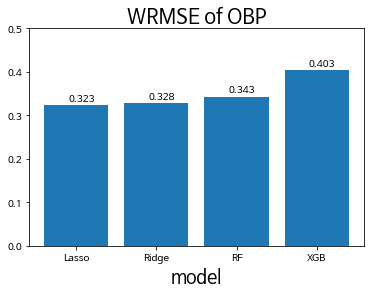

In [55]:
# 테스트 데이터셋(2018년)의 선수들의 OBP를 예측
Lasso_OBP = OBP_linear_models['Lasso'].predict(OBP_test.iloc[:,-5:])
Ridge_OBP = OBP_linear_models['Ridge'].predict(OBP_test.iloc[:,-5:])
RF_OBP = OBP_RF_models['RF'].predict(OBP_test.iloc[:,-5:])
XGB_OBP = XGB_OBP_gridsearch.predict(OBP_test.iloc[:,-5:])

# test 데이터의 WRMSE 계산
wrmse_score = [wrmse(OBP_test['OBP'], OBP_test['AB'], Lasso_OBP),
               wrmse(OBP_test['OBP'], OBP_test['AB'], Ridge_OBP),
               wrmse(OBP_test['OBP'], OBP_test['AB'], RF_OBP),
               wrmse(OBP_test['OBP'], OBP_test['AB'], XGB_OBP)]

x_lab = ['Lasso', 'Ridge', 'RF', 'XGB']

plt.bar(x_lab, wrmse_score)
plt.title('WRMSE of OBP', fontsize=20)
plt.xlabel('model', fontsize=18)
plt.ylabel('', fontsize=18)
plt.ylim(0,0.5)

# 막대그래프 위에 값을 표시해준다.
for i, v in enumerate(wrmse_score):
    plt.text(i-0.1, v + 0.01, str(np.round(v,3))) # x 좌표, y 좌표, 텍스트를 표현한다.
    
plt.show()

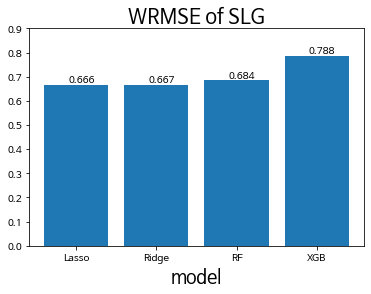

In [56]:
# 테스트 데이터셋(2018년)의 선수들의 SLG를 예측
Lasso_SLG = SLG_linear_models['Lasso'].predict(SLG_test.iloc[:,-5:])
Ridge_SLG = SLG_linear_models['Ridge'].predict(SLG_test.iloc[:,-5:])
RF_SLG = SLG_RF_models['RF'].predict(SLG_test.iloc[:,-5:])
XGB_SLG = XGB_SLG_gridsearch.predict(SLG_test.iloc[:,-5:])

# test데이터 WRMSE 계산
wrmse_score_SLG = [wrmse(SLG_test['SLG'], SLG_test['AB'], Lasso_SLG),
                   wrmse(SLG_test['SLG'], SLG_test['AB'], Ridge_SLG), 
                   wrmse(SLG_test['SLG'], SLG_test['AB'], RF_SLG),
                   wrmse(SLG_test['SLG'], SLG_test['AB'], XGB_SLG)]

x_lab = ['Lasso', 'Ridge', 'RF', 'XGB']

plt.bar(x_lab, wrmse_score_SLG)
plt.title('WRMSE of SLG', fontsize=20)
plt.xlabel('model', fontsize=18)
plt.ylabel('', fontsize=18)
plt.ylim(0, 0.9)

# 막대그래프 위에 값을 표시해준다.
for i, v in enumerate(wrmse_score_SLG):
    plt.text(i-0.1, v + 0.01, str(np.round(v,3))) # x 좌표, y 좌표, 텍스트를 표현한다.
plt.show()

1.4.3. 결과 해석과 평가

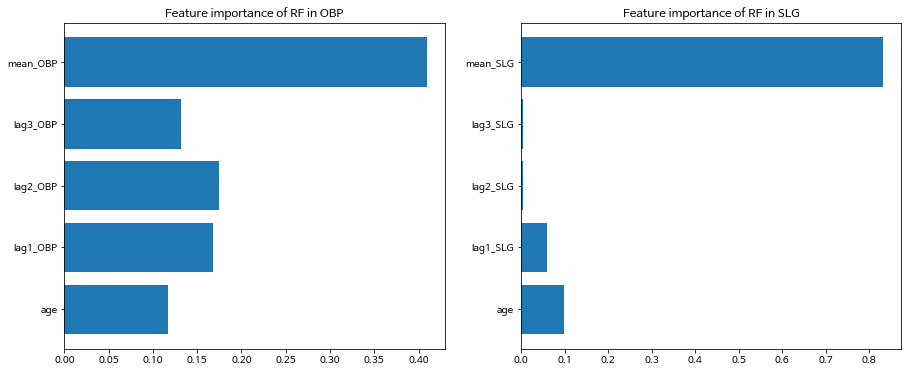

In [57]:
plt.figure(figsize=(15,6)) # 그래프의 크기 지정
plt.subplot(1,2,1) # 1행 2열의 첫번째(1,1) 그래프

#가로막대 그래프
plt.barh(OBP_train.iloc[:,-5:].columns,OBP_RF_models['RF'].feature_importances_) 

plt.title('Feature importance of RF in OBP')
plt.subplot(1,2,2) # 1행 2열의 두번째(1,2) 그래프
plt.barh(SLG_train.iloc[:,-5:].columns,SLG_RF_models['RF'].feature_importances_)
plt.title('Feature importance of RF in SLG')
plt.show()

In [58]:
# Lasso에서 GridSearchCV로 탐색한 최적의 alpha값 출력
print('Alpha : ', OBP_linear_models['Lasso'].alpha) 
# Lasso model의 선형 계수 값 출력
display(pd.DataFrame(OBP_linear_models['Lasso'].coef_.reshape(-1, 5),
                     columns=OBP_train.iloc[:,-5:].columns, index = ['coefficient']))

print('Alpha : ', SLG_linear_models['Lasso'].alpha)
display(pd.DataFrame(SLG_linear_models['Lasso'].coef_.reshape(-1, 5),
                     columns=SLG_train.iloc[:,-5:].columns, index = ['coefficient']))

Alpha :  0.0001


,age,lag1_OBP,lag2_OBP,lag3_OBP,mean_OBP
coefficient,0.003189,0.01047,0.006807,0.005519,0.863769


Alpha :  0.0001


,age,lag1_SLG,lag2_SLG,lag3_SLG,mean_SLG
coefficient,0.0049,0.080778,0.0,-0.0,0.836802


..

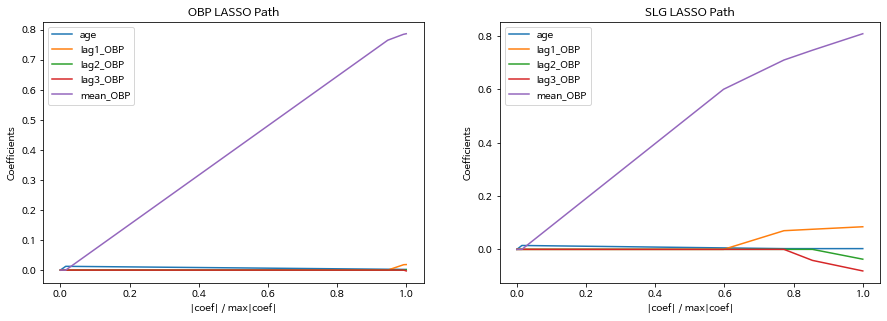

In [59]:
from sklearn.linear_model import lars_path
plt.figure(figsize=(15,4.8)) # 그래프 크기 지정
plt.subplot(1,2,1) # 1행 2열의 첫 번째(1행, 1열) 그래프 

# OBP 모델의 alpha 값의 변화에 따른 계수의 변화를 alpha, coefs에 저장한다.
alphas, _, coefs = lars_path(OBP_train.iloc[:,-5:].values, OBP_train['OBP'],
                             method='lasso', verbose=True)

# 피처별 alpha 값에 따른 선형 모델 계수의 절댓값의 합 
xx = np.sum(np.abs(coefs.T), axis=1)
# 계수의 절댓값 중 가장 큰 값으로 alpha에 따른 피처의 계수의 합을 나눈다. 
xx /= xx[-1]

plt.plot(xx, coefs.T)
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('OBP LASSO Path')
plt.axis('tight')
plt.legend(OBP_train.iloc[:,-5:].columns)

plt.subplot(1,2,2) # 1행 2열의 두 번째(1행, 2열) 그래프
# SLG 모델에서 alpha 값의 변화에 따른 계수의 변화를 alpha, coefs에 저장한다.
alphas, _, coefs = lars_path(SLG_train.iloc[:,-5:].values, SLG_train['SLG'],
                             method='lasso', verbose=True)
xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.plot(xx, coefs.T)
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('SLG LASSO Path')
plt.axis('tight')
plt.legend(OBP_train.iloc[:,-5:].columns)
plt.show()

# 1.5. 성능 향상을 위한 방법

1.5.1. 앙상블

In [60]:
print('OBP model averaging: ',
      wrmse(OBP_test['OBP'], OBP_test['AB'], (Lasso_OBP + RF_OBP) / 2))
print('SLG model averaging: ',
      wrmse(SLG_test['SLG'], OBP_test['AB'], (Lasso_SLG + RF_SLG) / 2))

OBP model averaging:  0.3264722528025719
SLG model averaging:  0.6683102798849887


1.5.2. 단순화된 모델 생성

In [61]:
# 전처리된 데이터를 다른 곳에 저장
sum_hf_yr_OBP_origin = sum_hf_yr_OBP.copy()

# 전체 희생타 계산
regular_season_df['SF'] = \
    regular_season_df[['H','BB','HBP']].sum(axis=1) / regular_season_df['OBP'] - \
    regular_season_df[['AB','BB','HBP']].sum(axis=1)
regular_season_df['SF'].fillna(0, inplace = True)
regular_season_df['SF'] = regular_season_df['SF'].apply(lambda x : round(x,0))

# 한 타수당 평균 희생타 계산 후 필요한 것만 추출
regular_season_df['SF_1'] = regular_season_df['SF'] / regular_season_df['AB']
regular_season_df_SF = regular_season_df[['batter_name','year','SF_1']]

#day_by_day에서 연도별 선수의 시즌 전반기 출루율과 관련된 성적 합 구하기 + BB, RBI 추가
sum_hf_yr_OBP = \
    day_by_day_df.loc[day_by_day_df['date'] <= 7.18].groupby(['batter_name','year'])[
    'AB','H','BB','HBP','RBI', '2B', '3B', 'HR'].sum().reset_index()
#day_by_day와 regular season에서 구한 희생타 관련 데이터를 합치기
sum_hf_yr_OBP = sum_hf_yr_OBP.merge(regular_season_df_SF, how = 'left',
                                    on=['batter_name','year'])

# 한 타수당 평균 희생타 계산
sum_hf_yr_OBP['SF'] = \
    (sum_hf_yr_OBP['SF_1']*sum_hf_yr_OBP['AB']).apply(lambda x: round(x,0))
sum_hf_yr_OBP.drop('SF_1',axis = 1, inplace = True)

# 전반기 OBP(출루율 계산)
sum_hf_yr_OBP['OBP'] = sum_hf_yr_OBP[['H', 'BB', 'HBP']].sum(axis = 1) / \
                       sum_hf_yr_OBP[['AB', 'BB', 'HBP','SF']].sum(axis = 1)
sum_hf_yr_OBP['OBP'].fillna(0, inplace = True)

# TB 계산
sum_hf_yr_OBP['TB'] =  sum_hf_yr_OBP['H'] + sum_hf_yr_OBP['2B']*2 + \
                       sum_hf_yr_OBP['3B']*3 + sum_hf_yr_OBP['HR']*4
sum_hf_yr_OBP = sum_hf_yr_OBP[['batter_name','year','AB','OBP', 'BB', 'TB', 'RBI']]

# 나이 추가
sum_hf_yr_OBP = sum_hf_yr_OBP.merge(regular_season_df[['batter_name','year','age']],
                                    how = 'left', on=['batter_name','year'])

# 평균 OBP 추가
sum_hf_yr_OBP = sum_hf_yr_OBP.merge(player_OBP_mean[['batter_name', 'mean_OBP']],
                                    how ='left', on="batter_name")
sum_hf_yr_OBP = \
    sum_hf_yr_OBP.loc[~sum_hf_yr_OBP['mean_OBP'].isna()].reset_index(drop=True)

In [62]:
# 각 변수에 대한 1년 전 성적 생성
sum_hf_yr_OBP = lag_function(sum_hf_yr_OBP, "BB", 1)
sum_hf_yr_OBP = lag_function(sum_hf_yr_OBP, "TB", 1)
sum_hf_yr_OBP = lag_function(sum_hf_yr_OBP, "RBI", 1)
sum_hf_yr_OBP = lag_function(sum_hf_yr_OBP, "OBP", 1)

sum_hf_yr_OBP = sum_hf_yr_OBP.dropna() # 결측치 포함한 행 제거

# 변수 리스트 지정
feature_list_1 = ['age', 'lag1_OBP', 'mean_OBP']
feature_list_2 = ['age', 'lag1_BB', 'lag1_TB', 'lag1_RBI','lag1_OBP', 'mean_OBP']

In [63]:
# 학습시킬 데이터 30타수 이상만 학습
sum_hf_yr_OBP= sum_hf_yr_OBP.loc[sum_hf_yr_OBP['AB']>=30] 

# 2018년 test로 나누고 나머지는 학습
OBP_train = sum_hf_yr_OBP.loc[sum_hf_yr_OBP['year'] != 2018]
OBP_test = sum_hf_yr_OBP.loc[sum_hf_yr_OBP['year'] == 2018]

# grid search를 이용해 학습한다.
OBP_RF_models_1 = {
    'RF': GridSearchCV(
        RandomForestRegressor(random_state=42), param_grid=RF_params, n_jobs=-1
        ).fit(OBP_train.loc[:,feature_list_1], OBP_train['OBP']).best_estimator_}

OBP_RF_models_2 = {
    'RF': GridSearchCV(
        RandomForestRegressor(random_state=42), param_grid=RF_params, n_jobs=-1
        ).fit(OBP_train.loc[:,feature_list_2], OBP_train['OBP']).best_estimator_}

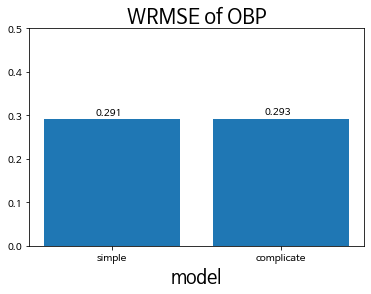

In [64]:
# 예측
RF_OBP_1 = OBP_RF_models_1['RF'].predict(OBP_test.loc[:,feature_list_1])
RF_OBP_2 = OBP_RF_models_2['RF'].predict(OBP_test.loc[:,feature_list_2])

# wrmse 계산
wrmse_score = [wrmse(OBP_test['OBP'],OBP_test['AB'],RF_OBP_1) ,
               wrmse(OBP_test['OBP'],OBP_test['AB'],RF_OBP_2)]
x_lab = ['simple', 'complicate']

plt.bar(x_lab, wrmse_score)
plt.title('WRMSE of OBP', fontsize=20)
plt.xlabel('model', fontsize=18)
plt.ylabel('', fontsize=18)
plt.ylim(0,0.5)
# 막대그래프 위에 값을 표시해준다.
for i, v in enumerate(wrmse_score):
    plt.text(i-0.1, v + 0.01, str(np.round(v,3))) # x 좌표, y좌표, 텍스트 표시
plt.show()

In [65]:
# 최종 제출을 위한 원래 데이터 복구 
sum_hf_yr_OBP = sum_hf_yr_OBP_origin.copy()

1.5.3. 테스트 데이터 정제

In [ ]:
submission = pd.read_csv('C:/dacon/ch01/dataset/submission.csv')
submission['year'] = 2019 # 연도 기입

# 2019년의 Age(나이) 계산
batter_year_born = regular_season_df[['batter_id','batter_name','year_born']].copy()
# 중복선수 제거
batter_year_born = batter_year_born.drop_duplicates().reset_index(drop=True) 

submission = submission.merge(batter_year_born, how='left',
                              on=['batter_id', 'batter_name'])
submission['age'] = submission['year'] - \
                    submission['year_born'].apply(lambda x: int(x[:4]))
submission.head()

In [ ]:
# submission OBP, SLG 파일 2개 만들어 합치기 
submission_OBP = submission.copy()
submission_SLG = submission.copy()

In [ ]:
# 앞서 전처리한 데이터를 이용해 평균 성적 기입
submission_OBP = submission_OBP.merge(
    sum_hf_yr_OBP[['batter_name','mean_OBP']].drop_duplicates().reset_index(drop=True),
    how = 'left', on ='batter_name')

# 앞서 전처리한 데이터를 이용해 과거 성적 값 채우기
for i in [1,2,3]:
    temp_lag_df = sum_hf_yr_OBP.loc[
        (sum_hf_yr_OBP['year'] == (2019 - i)) &
        (sum_hf_yr_OBP['AB']>=30),['batter_name','OBP']].copy()
    temp_lag_df.rename(columns={'OBP':'lag'+str(i)+'_OBP'}, inplace=True)
    submission_OBP = submission_OBP.merge(temp_lag_df, how='left', on='batter_name')

submission_OBP.head()

In [ ]:
submission_OBP['batter_name'].loc[submission_OBP['mean_OBP'].isna()].values

In [ ]:
for batter_name in ["김주찬", "이범호"]:
     # 30타수 이상인 해당선수의 인덱스(Boolean)
    cond_regular = (regular_season_df['AB'] >= 30) & \
                   (regular_season_df['batter_name'] == batter_name)
    
    # 타수를 고려해 평균 OBP 계산
    mean_OBP = sum(regular_season_df.loc[cond_regular,'AB'] * \
                   regular_season_df.loc[cond_regular,'OBP']) / \
               sum(regular_season_df.loc[cond_regular,'AB'])
    
    submission_OBP.loc[(submission_OBP['batter_name'] == batter_name),'mean_OBP'] = \
        mean_OBP
    
    # regular_season_Batter으로부터 1, 2, 3년 전 성적 구하기
    cond_sub = submission_OBP['batter_name'] == batter_name
    submission_OBP.loc[cond_sub,'lag1_OBP'] = regular_season_df.loc[
        (cond_regular) & (regular_season_df['year']==2018),'OBP'].values
    submission_OBP.loc[cond_sub,'lag2_OBP'] = regular_season_df.loc[
        (cond_regular) & (regular_season_df['year']==2017),'OBP'].values
    submission_OBP.loc[cond_sub,'lag3_OBP'] = regular_season_df.loc[
        (cond_regular) & (regular_season_df['year']==2016),'OBP'].values

In [ ]:
for i in np.where(submission_OBP['batter_name'].isin(["고명성","전민재","김철호","신범수","이병휘"])):
    #submission_OBP.loc[i,'mean_OBP'] = season_OBP_mean.loc[season_OBP_mean['year']==2018,'mean_OBP'].values
    submission_OBP.loc[i,'mean_OBP'] = \
        season_OBP_mean.loc[season_OBP_mean['year']==2018,'mean_OBP']

In [ ]:
for batter_name in ["전병우","샌즈"]:
    # 30 타수 이상인 해당 선수의 index 추출
    cond_regular = (regular_season_df['AB']>=30) & \
                   (regular_season_df['batter_name']==batter_name) 

# 타수를 고려해 선수의 평균 OBP계산
mean_OBP = sum(regular_season_df.loc[cond_regular,'AB'] * \
               regular_season_df.loc[cond_regular,'OBP']) / \
           sum(regular_season_df.loc[cond_regular,'AB'])
    
submission_OBP.loc[(submission_OBP['batter_name'] == batter_name),'mean_OBP'] = mean_OBP

cond_sub = submission_OBP['batter_name'] == batter_name

# 2018년 데이터로부터 2019년의 1년 전 성적 기입
submission_OBP.loc[cond_sub,'lag1_OBP'] = regular_season_df.loc[
    (cond_regular)&(regular_season_df['year']==2018),'OBP'].values

In [ ]:
# 평균 성적이 결측치인 선수들에 대해 평균 OBP의 하위 25% 성적 기입
submission_OBP.loc[submission_OBP['mean_OBP'].isna(),'mean_OBP'] = \
    np.quantile(player_OBP_mean['mean_OBP'],0.25)

In [ ]:
for i in [1,2,3]: 
    # i년 전 OBP 결측치 제거
    submission_OBP = lag_na_fill(submission_OBP, 'OBP', i, season_OBP_mean)
submission_OBP.head()

In [ ]:
# 앞서 전처리한 데이터로 평균 SLG 값 기입
submission_SLG = submission_SLG.merge(
    sum_hf_yr_SLG[['batter_name','mean_SLG']].drop_duplicates().reset_index(drop=True),
    how='left', on='batter_name')

# 앞서 전처리한 데이터에서 과거 SLG 값 채우기
for i in [1,2,3]:
    temp_lag_df = sum_hf_yr_SLG.loc[(sum_hf_yr_SLG['year'] == (2019 - i)) &
        (sum_hf_yr_SLG['AB']>=30),['batter_name','SLG']].copy()
    
    temp_lag_df.rename(columns={'SLG':'lag'+str(i)+'_SLG'}, inplace=True)
    
    submission_SLG = submission_SLG.merge(temp_lag_df, how='left', on='batter_name')

In [ ]:
submission_SLG['batter_name'].loc[submission_SLG['mean_SLG'].isna()].values

In [ ]:
for batter_name in ["김주찬", "이범호"]:
     # mean_SLG 계산
    cond_regular = (regular_season_df['AB'] >= 30) & \
                   (regular_season_df['batter_name'] == batter_name)
    
    # 타수를 고려해 선수의 평균 SLG 계산
    mean_SLG = sum(regular_season_df.loc[cond_regular,'AB'] * \
                   regular_season_df.loc[cond_regular,'SLG']) / \
               sum(regular_season_df.loc[cond_regular,'AB'])
    
    submission_SLG.loc[(submission_SLG['batter_name'] == batter_name), 'mean_SLG'] = \
        mean_SLG
    
    # regular_season_Batter으로부터 1, 2, 3년 전 성적 구하기
    cond_sub = submission_SLG['batter_name'] == batter_name
    
    submission_SLG.loc[cond_sub,'lag1_SLG'] = regular_season_df.loc[
        (cond_regular) & (regular_season_df['year'] == 2018),'SLG'].values
    submission_SLG.loc[cond_sub,'lag2_SLG'] = regular_season_df.loc[
        (cond_regular) & (regular_season_df['year'] == 2017),'SLG'].values
    submission_SLG.loc[cond_sub,'lag3_SLG'] = regular_season_df.loc[
        (cond_regular) & (regular_season_df['year'] == 2016),'SLG'].values


In [ ]:
for i in np.where(submission_SLG['batter_name'].isin(
    ["고명성","전민재","김철호","신범수","이병휘"])):
     # 위의 해당 선수들의 평균 SLG 평균값으로 대체
    #submission_SLG.loc[i,'mean_SLG'] = season_SLG_mean.loc[season_SLG_mean['year']==2018,'mean_SLG'].values
    submission_SLG.loc[i,'mean_SLG'] = \
        season_SLG_mean.loc[season_SLG_mean['year']==2018,'mean_SLG']

In [ ]:
for batter_name in ["전병우","샌즈"]:
    
    # 30타수 이상인 해당선수의 인덱스(Boolean) 
    cond_regular = (regular_season_df['AB']>=30)&\
(regular_season_df['batter_name']==batter_name)

# 타수를 고려한 평균 SLG 계산
mean_SLG = sum(regular_season_df.loc[cond_regular,'AB']*
regular_season_df.loc[cond_regular,'SLG']) / sum(regular_season_df.loc[cond_regular,'AB'])

# 해당 선수의 평균 SLG 값 기입
submission_SLG.loc[(submission_SLG['batter_name'] == batter_name),
'mean_SLG'] = mean_SLG

# 해당 선수의 1년 전 SLG값 기입
cond_sub = submission_SLG['batter_name'] == batter_name
submission_SLG.loc[cond_sub,'lag1_SLG'] = regular_season_df.loc[(cond_regular)&
(regular_season_df['year']==2018),'SLG'].values

In [ ]:
# 평균 성적이 결측치인 선수들에 대해 평균 SLG의 하위 25% 성적 기입
submission_SLG.loc[submission_SLG['mean_SLG'].isna(),'mean_SLG'] = \
    np.quantile(player_SLG_mean['mean_SLG'],0.25)

In [ ]:
for i in [1,2,3]:
    # i년 전 SLG 성적 결측치 처리
    submission_SLG = lag_na_fill(submission_SLG, 'SLG', i, season_SLG_mean)
submission_SLG.head()

In [ ]:
# Random Forests를 이용해 OBP 예측
predict_OBP = OBP_RF_models['RF'].predict(submission_OBP.iloc[:,-5:]) 
# Lasso를 이용해 SLG 예측
predict_SLG = SLG_linear_models ['Lasso'].predict(submission_SLG.iloc[:,-5:])

In [ ]:
final_submission = submission[['batter_id','batter_name']]
final_submission['OPS'] = predict_SLG + predict_OBP # OBP + SLG = OPS 
final_submission.head(10)

1.5.4. 반발계수의 변화
>반발 계수(反撥係數, 영어: coefficient of restitution, COR)는 물체의 충돌 전후 속도의 비율을 나타내는 분수이다. 반발 계수가 1인 물체는 탄성 충돌을 하며, 반발 계수가 1보다 작은 물체는 비탄성 충돌을 한다. 반발 계수가 0이면 완전 비탄성 충돌을 하며, 충돌한 물체와 붙어서 튀지 않는다.

In [ ]:
# 시즌별 전체 OBP 계산(30타수 이상인 선수들의 기록만 이용)
season_OBP = \
    regular_season_df.loc[regular_season_df['AB'] >= 30].groupby('year').agg(
        {'AB':'sum', 'H':'sum', 'BB':'sum', 'HBP':'sum', 'SF':'sum'}).reset_index()

season_OBP['OBP'] = season_OBP[['H','BB','HBP']].sum(axis=1) / \
                    season_OBP[['AB','BB','HBP','SF']].sum(axis=1)

# 시즌별 전체 SLG 계산(30타수 이상인 선수들의 기록만 이용)
season_SLG = \
    regular_season_df.loc[regular_season_df['AB']>=30].groupby('year').agg(
        {'AB':'sum', 'H':'sum', '2B':'sum', '3B':'sum', 'HR':'sum'}).reset_index()

season_SLG['SLG'] = ((season_SLG['H'] - season_SLG[['2B','3B','HR']].sum(axis=1)) + \
                     season_SLG['2B']*2+season_SLG['3B']*3+ season_SLG['HR']*4) / \
                    season_SLG['AB']

# season_OBP와 season_SLG를 병합 후 season_OPS를 생성해 OPS 계산
season_OPS = pd.merge(season_OBP[['year','OBP']],season_SLG[['year', 'SLG']], on = 'year')
season_OPS['OPS'] = season_OPS['OBP'] + season_OPS['SLG']

# 시즌별 전체 홈런 수와 한 선수당 평균 홈런 수 계산
season_HR = regular_season_df.loc[regular_season_df['AB']>=30].groupby('year').agg(
    {'HR':['sum','mean','count']}).reset_index()
season_HR.columns = ['year', 'sum_HR', 'mean_HR', 'count']

# 기존의 OPS 데이터셋과 병합
season_OPS = season_OPS.merge(season_HR,on ='year' ,how='left')
display(season_OPS.tail())

In [ ]:
#2018년의 평균 홈런 개수를 시즌별 평균 홈런 수에서 뺀다(HR_diff)
season_OPS['HR_diff'] = season_OPS['mean_HR'] - season_OPS['mean_HR'].iloc[-1]
difference = season_OPS.sort_values(by = 'HR_diff')[['year','OPS','HR_diff']]
display(difference.reset_index(drop=True).head(12))

In [ ]:
# 2000년도 이전의 데이터 수가 충분치 않아 고려하지 않는다.
season_OPS.loc[season_OPS['year']>2000]

In [ ]:
final_submission['OPS'] = final_submission['OPS'] - 0.038
display(final_submission.head(10))
final_submission.to_csv('submission.csv', index=False) # 최종 제출파일 생성